# Breast Cancer Notebook

This notebook documents preprocessing steps, classification, and evaluation for the provided breast-cancer dataset.

**KAGGLE Competition**\
The code for the specific Kaggle predictions and used classifier/preprocessing steps is found at the end (Appendix).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import clone

# training
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# evaluation
from sklearn.metrics import (
    accuracy_score, 
    balanced_accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)


## 1 Load Dataset

This *Breast Cancer* dataset can be used to predict if a patient has a "reurrence-events" or "no-recurrence-events", i.e. give a malignant or benign diagnosis.

It includes
- **breast-cancer-diagnostic.shuf.lrn.csv**: training dataset
- **breast-cancer-diagnostic.shuf.tes.csv**: test/validation dataset 
- **breast-cancer-diagnostic.shuf.sol.ex.csv**: sample solutions

In [3]:
datafolder = "../../datasets/BreastCancer"

training_file = datafolder + "/breast-cancer-diagnostic.shuf.lrn.csv"
validation_file = datafolder + "/breast-cancer-diagnostic.shuf.tes.csv"
sample_solution_file = datafolder + "/breast-cancer-diagnostic.shuf.sol.ex.csv"

training_df = pd.read_csv(training_file)
validation_df = pd.read_csv(validation_file)

print("training df shape:", training_df.shape)   
training_df.head()

training df shape: (285, 32)


ID  class  radiusMean   textureMean   perimeterMean   areaMean  \
0  8813129  False       13.27         17.02           84.55      546.4   
1   898678  False       12.06         18.90           76.66      445.3   
2   917896  False       13.71         18.68           88.73      571.0   
3   869691   True       11.80         16.58           78.99      432.0   
4  9110127   True       18.03         16.85          117.50      990.0   

    smoothnessMean   compactnessMean   concavityMean   concavePointsMean  ...  \
0          0.08445           0.04994         0.03554            0.024560  ...   
1          0.08386           0.05794         0.00751            0.008488  ...   
2          0.09916           0.10700         0.05385            0.037830  ...   
3          0.10910           0.17000         0.16590            0.074150  ...   
4          0.08947           0.12320         0.10900            0.062540  ...   

    radiusWorst   textureWorst   perimeterWorst   areaWorst   smoothnessWorst  \
0         15.14          23.60            98.84       708.8            0.1276   
1         13.64          27.06            86.54       562.6            0.1289   
2         15.11          25.63            99.43       701.9            0.1425   
3         13.74          26.38            91.93       591.7            0.1385   
4         20.38          22.02           133.30      1292.0            0.1263   

    compactnessWorst   concavityWorst   concavePointsWorst   symmetryWorst  \
0             0.1311          0.17860              0.09678          0.2506   
1             0.1352          0.04506              0.05093          0.2880   
2             0.2566          0.19350              0.12840          0.2849   
3             0.4092          0.45040              0.18650          0.5774   
4             0.2666          0.42900              0.15350          0.2842   

    fractalDimensionWorst  
0                 0.07623  
1                 0.08083  
2                 0.09031  
3                 0.10300  
4                 0.08225  

[5 rows x 32 columns]

## 2 Inspect Dataset

### 2.1 Dataset Description

In [4]:
print(f"""
The training dataset has following properties:
    - Number of Instances: {training_df.shape[0]}
    - Number of Features: {training_df.shape[1]-1}
    - Number of Target Attributes: 1
    - Has missing values: {'yes' if training_df.isnull().sum().sum() > 0 else 'no'}
    - Types of attributes: {training_df.dtypes.value_counts().to_dict()}
    - Duplicate Instances: {training_df.duplicated().sum()}
""")

print(f"""
The validation dataset has following properties:
    - Number of Instances: {validation_df.shape[0]}
    - Has missing values: {'yes' if validation_df.isnull().sum().sum() > 0 else 'no'}
    - Duplicate Instances: {validation_df.duplicated().sum()}
""")




The training dataset has following properties:
    - Number of Instances: 285
    - Number of Features: 31
    - Number of Target Attributes: 1
    - Has missing values: no
    - Types of attributes: {dtype('float64'): 30, dtype('int64'): 1, dtype('bool'): 1}
    - Duplicate Instances: 0


The validation dataset has following properties:
    - Number of Instances: 284
    - Has missing values: no
    - Duplicate Instances: 0



### 2.2 Feature Variables

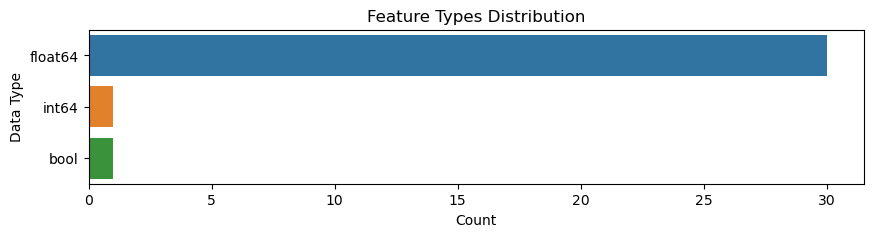

In [5]:
dtype_df = pd.DataFrame(training_df.dtypes, columns=['dtype'])

fig, ax = plt.subplots(figsize=(10, 2))
sns.countplot(data=dtype_df, y='dtype', order=dtype_df['dtype'].value_counts().index, ax=ax)
ax.set_xlabel('Count')
ax.set_ylabel('Data Type')
ax.set_title('Feature Types Distribution')

plt.show()

In [6]:
summary_table = pd.DataFrame({
    'Attribute': training_df.columns,
    'Data Type': training_df.dtypes.values,
    'Missing Values': training_df.isnull().sum().values,
    'Min': training_df.min(numeric_only=True).reindex(training_df.columns).values,
    'Max': training_df.max(numeric_only=True).reindex(training_df.columns).values
})


# sort according to attribute name, (ID and class at top)
summary_table = summary_table.sort_values(by='Attribute').reset_index(drop=True)

priority = ['ID', 'class']
priority_rows = summary_table[summary_table['Attribute'].isin(priority)]
other_rows = summary_table[~summary_table['Attribute'].isin(priority)]
summary_table = pd.concat([priority_rows, other_rows], ignore_index=True)

display(summary_table)

Attribute Data Type  Missing Values       Min        Max
0                        ID     int64               0      8670  911320501
1                     class      bool               0     False       True
2                  areaMean   float64               0     143.5     2501.0
3                areaStdErr   float64               0     7.254      542.2
4                 areaWorst   float64               0     185.2     4254.0
5           compactnessMean   float64               0   0.01938     0.3454
6         compactnessStdErr   float64               0  0.002252     0.1064
7          compactnessWorst   float64               0   0.02729     0.9379
8         concavePointsMean   float64               0       0.0     0.1689
9       concavePointsStdErr   float64               0       0.0    0.05279
10       concavePointsWorst   float64               0       0.0     0.2903
11            concavityMean   float64               0       0.0     0.4108
12          concavityStdErr   float64               0       0.0      0.396
13           concavityWorst   float64               0       0.0     0.9019
14     fractalDimensionMean   float64               0   0.05025    0.09502
15   fractalDimensionStdErr   float64               0  0.000968    0.02984
16    fractalDimensionWorst   float64               0   0.05843     0.1431
17            perimeterMean   float64               0     43.79      186.9
18          perimeterStdErr   float64               0    0.7714      18.65
19           perimeterWorst   float64               0     50.41      251.2
20             radiusStdErr   float64               0    0.1166      2.547
21              radiusWorst   float64               0      7.93      36.04
22           smoothnessMean   float64               0   0.05263     0.1634
23         smoothnessStdErr   float64               0  0.001713    0.03113
24          smoothnessWorst   float64               0   0.07117     0.2184
25             symmetryMean   float64               0    0.1215      0.304
26           symmetryStdErr   float64               0  0.009539    0.07895
27            symmetryWorst   float64               0    0.1603     0.5774
28              textureMean   float64               0     10.38      39.28
29            textureStdErr   float64               0    0.3602      4.885
30             textureWorst   float64               0     12.49      49.54
31               radiusMean   float64               0     6.981      27.42

- **ID** (*Integer*): Each record has a unique identifier, which is not a predictive feature but used for reference.
- **class** (*Boolean*): Target attribute indicating whether the tumor is malignant (True) or benign (False).
- All other *numerical* attributes are cell nucleus features, and each measurement (e.g. `radius` or `texture`) appears in three variants:
    - **Mean**: average value across all cells
    - **StdErr**: standard error of the mean (variation of the measurement)
    - **Worst**: largest value observed amoung the cells (indicating extreme abnormality)

### 2.2.1 Numeric Features

In [7]:
display(training_df.describe().T)

count          mean           std          min  \
ID                       285.0  2.861498e+07  1.204247e+08  8670.000000   
radiusMean               285.0  1.406867e+01  3.486377e+00     6.981000   
 textureMean             285.0  1.911621e+01  4.516754e+00    10.380000   
 perimeterMean           285.0  9.155505e+01  2.402869e+01    43.790000   
 areaMean                285.0  6.496179e+02  3.439793e+02   143.500000   
 smoothnessMean          285.0  9.585119e-02  1.389354e-02     0.052630   
 compactnessMean         285.0  1.026052e-01  5.142201e-02     0.019380   
 concavityMean           285.0  8.558703e-02  7.571744e-02     0.000000   
 concavePointsMean       285.0  4.792968e-02  3.740917e-02     0.000000   
 symmetryMean            285.0  1.829077e-01  2.860628e-02     0.121500   
 fractalDimensionMean    285.0  6.261105e-02  6.849923e-03     0.050250   
 radiusStdErr            285.0  3.962046e-01  2.530803e-01     0.116600   
 textureStdErr           285.0  1.221592e+00  5.627880e-01     0.360200   
 perimeterStdErr         285.0  2.790815e+00  1.792693e+00     0.771400   
 areaStdErr              285.0  3.943303e+01  4.402047e+01     7.254000   
 smoothnessStdErr        285.0  7.049260e-03  3.126304e-03     0.001713   
 compactnessStdErr       285.0  2.491860e-02  1.648913e-02     0.002252   
 concavityStdErr         285.0  3.066300e-02  3.046943e-02     0.000000   
 concavePointsStdErr     285.0  1.164288e-02  6.458236e-03     0.000000   
 symmetryStdErr          285.0  2.037879e-02  8.196268e-03     0.009539   
 fractalDimensionStdErr  285.0  3.749341e-03  2.781035e-03     0.000968   
 radiusWorst             285.0  1.621435e+01  4.820742e+00     7.930000   
 textureWorst            285.0  2.556874e+01  6.318778e+00    12.490000   
 perimeterWorst          285.0  1.068662e+02  3.339031e+01    50.410000   
 areaWorst               285.0  8.782263e+02  5.722572e+02   185.200000   
 smoothnessWorst         285.0  1.319402e-01  2.237688e-02     0.071170   
 compactnessWorst        285.0  2.510419e-01  1.537947e-01     0.027290   
 concavityWorst          285.0  2.632505e-01  1.997835e-01     0.000000   
 concavePointsWorst      285.0  1.137295e-01  6.746113e-02     0.000000   
 symmetryWorst           285.0  2.916361e-01  6.295745e-02     0.160300   
 fractalDimensionWorst   285.0  8.334095e-02  1.633496e-02     0.058430   

                                   25%            50%           75%  \
ID                       871149.000000  906539.000000  8.811523e+06   
radiusMean                   11.690000      13.280000  1.607000e+01   
 textureMean                 15.900000      18.700000  2.184000e+01   
 perimeterMean               74.680000      86.100000  1.058000e+02   
 areaMean                   418.700000     546.400000  7.978000e+02   
 smoothnessMean               0.086000       0.095140  1.051000e-01   
 compactnessMean              0.062190       0.092280  1.304000e-01   
 concavityMean                0.026880       0.061950  1.226000e-01   
 concavePointsMean            0.020690       0.033260  7.340000e-02   
 symmetryMean                 0.162100       0.181400  1.976000e-01   
 fractalDimensionMean         0.057800       0.061320  6.588000e-02   
 radiusStdErr                 0.232300       0.331600  4.681000e-01   
 textureStdErr                0.856100       1.093000  1.457000e+00   
 perimeterStdErr              1.683000       2.346000  3.267000e+00   
 areaStdErr                  18.020000      25.030000  4.491000e+01   
 smoothnessStdErr             0.005096       0.006294  8.074000e-03   
 compactnessStdErr            0.013400       0.021010  3.245000e-02   
 concavityStdErr              0.014530       0.025720  3.950000e-02   
 concavePointsStdErr          0.007620       0.010650  1.444000e-02   
 symmetryStdErr               0.015430       0.018430  2.308000e-02   
 fractalDimensionStdErr       0.002278       0.003249  4.445000e-03   
 radiusWorst                 13.010000      14.970000  1.90700

In [8]:
def plot_feature_distributions(cols, suptitle='Feature distribution'):
    n_cols = 5
    nrows = int(np.ceil(len(cols) / n_cols))
    fig, axes = plt.subplots(
        nrows=nrows, 
        ncols=n_cols, 
        figsize=(n_cols*4, nrows*3), 
        sharex=False, 
        sharey=False
    )
    axes = np.array(axes).reshape(-1)

    palette = sns.color_palette('rocket', n_cols)

    for i, col in enumerate(cols):
        ax = axes[i]
        s = training_df[col].dropna()

        sns.histplot(
            s, 
            bins='auto', 
            kde=True, 
            ax=ax, 
            color=palette[i % len(palette)], 
            edgecolor='white', 
            linewidth=0.5, 
            alpha=0.9
        )

        ax.set_title(col, fontsize=16)
        ax.set_xlabel("")
        ax.set_ylabel("")
        sns.despine(ax=ax)

    for j in range(len(cols), len(axes)):
        axes[j].axis('off')

    fig.suptitle(suptitle, fontsize=17)
    plt.tight_layout()
    plt.savefig("feature-distribution-mean.png", format="png")
    plt.show()


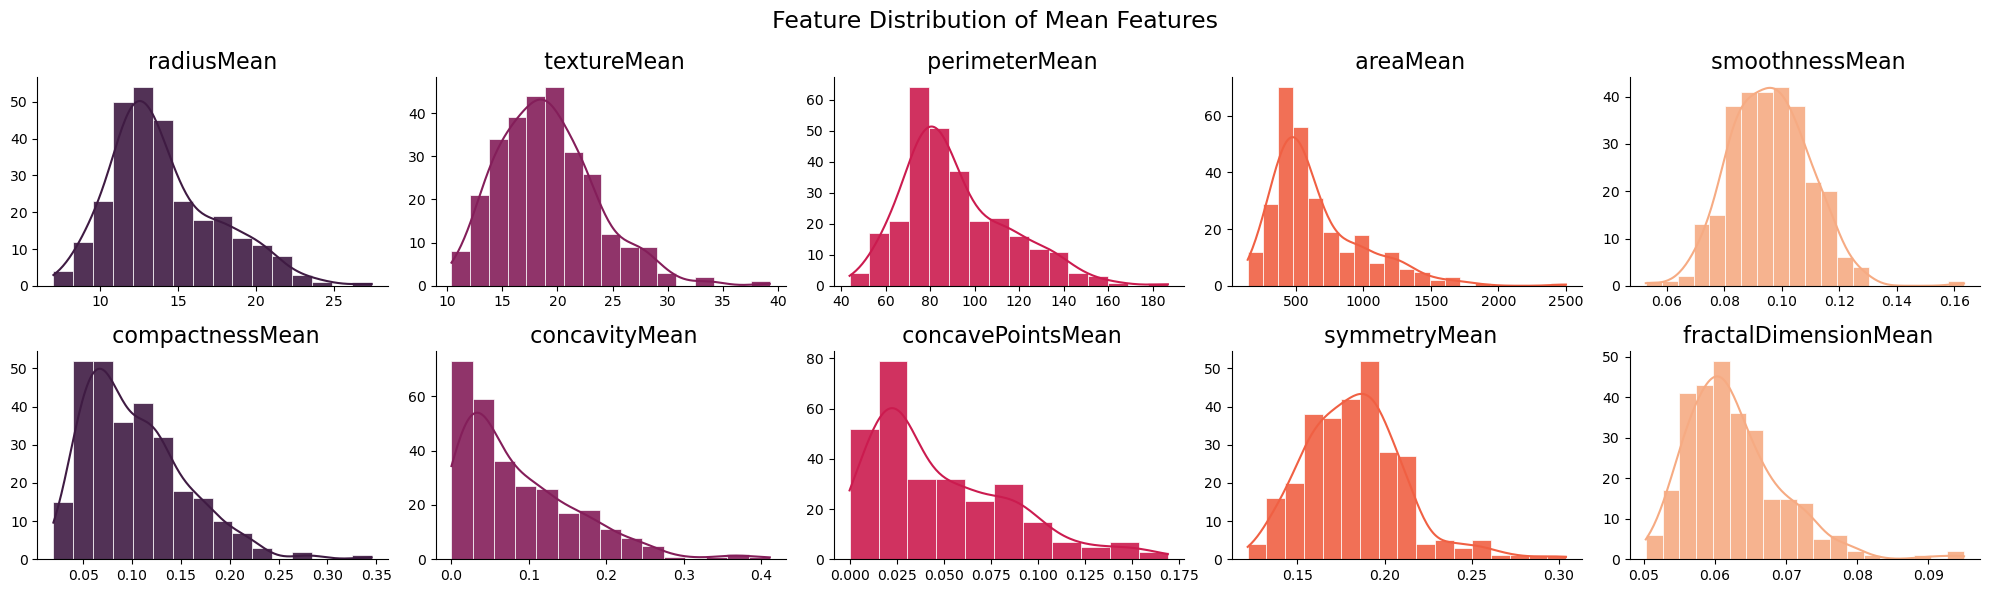

In [9]:
cols = [col for col in training_df.columns if col.endswith('Mean')]
plot_feature_distributions(cols, 'Feature Distribution of Mean Features')

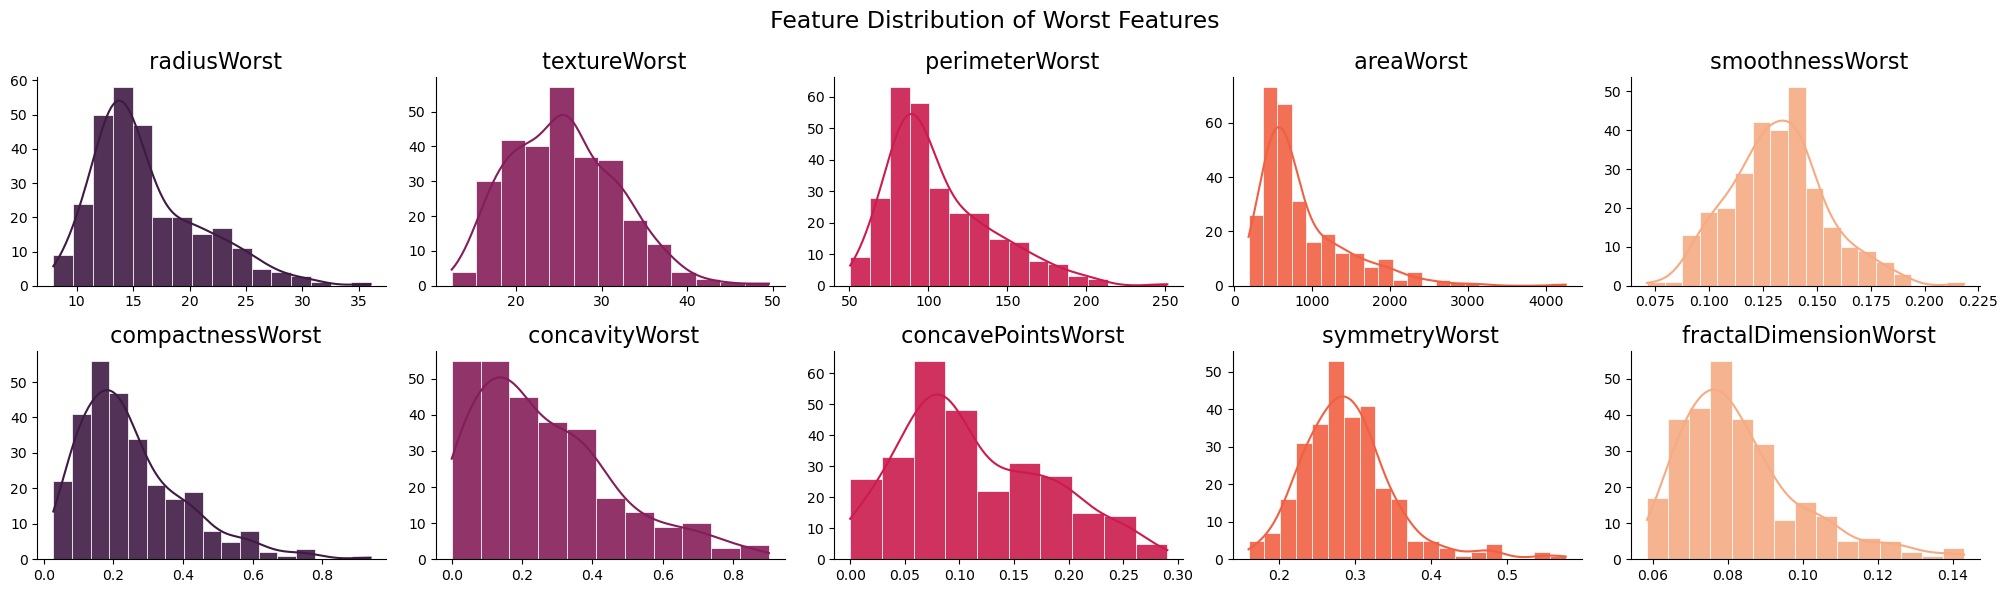

In [10]:
cols = [col for col in training_df.columns if col.endswith('Worst')]
plot_feature_distributions(cols, 'Feature Distribution of Worst Features')

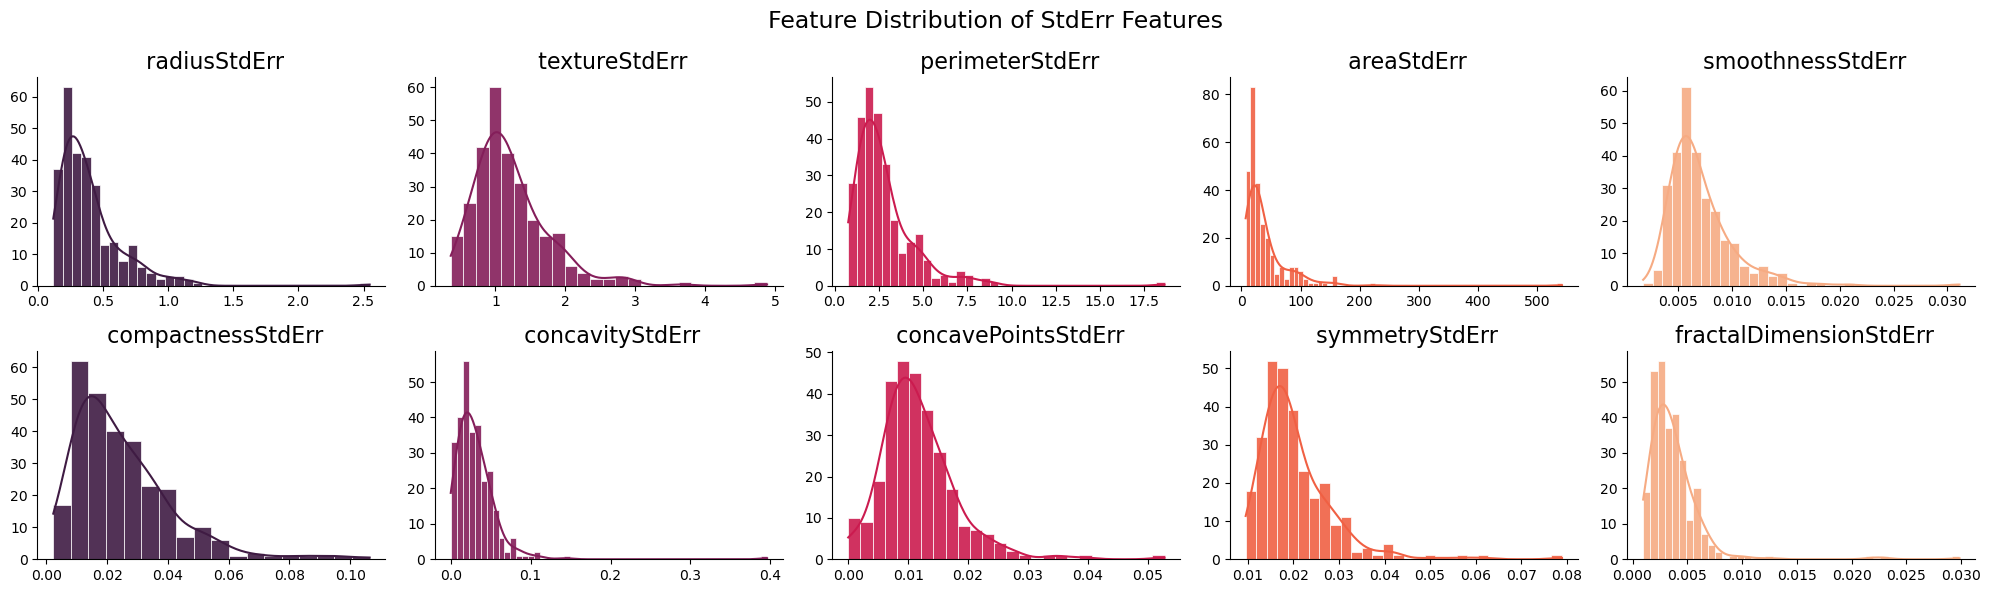

In [11]:
cols = [col for col in training_df.columns if col.endswith('StdErr')]
plot_feature_distributions(cols, 'Feature Distribution of StdErr Features')

#### 2.2.2 Strip whitespace from column names

In [12]:
training_df.rename(columns=lambda x: x.strip(), inplace=True)
validation_df.rename(columns=lambda x: x.strip(), inplace=True)

print('Stripped whitespaces from column names. Columns now:')
training_df.columns.tolist()

Stripped whitespaces from column names. Columns now:


['ID',
 'class',
 'radiusMean',
 'textureMean',
 'perimeterMean',
 'areaMean',
 'smoothnessMean',
 'compactnessMean',
 'concavityMean',
 'concavePointsMean',
 'symmetryMean',
 'fractalDimensionMean',
 'radiusStdErr',
 'textureStdErr',
 'perimeterStdErr',
 'areaStdErr',
 'smoothnessStdErr',
 'compactnessStdErr',
 'concavityStdErr',
 'concavePointsStdErr',
 'symmetryStdErr',
 'fractalDimensionStdErr',
 'radiusWorst',
 'textureWorst',
 'perimeterWorst',
 'areaWorst',
 'smoothnessWorst',
 'compactnessWorst',
 'concavityWorst',
 'concavePointsWorst',
 'symmetryWorst',
 'fractalDimensionWorst']

### 2.3 Target Variable

Text(0.5, 1.0, 'Class Distribution in Training Set')

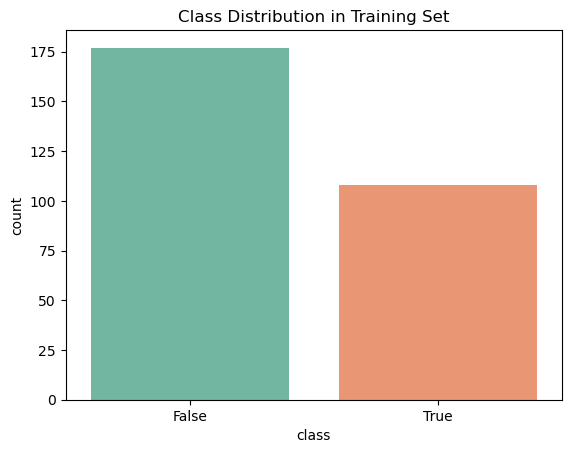

In [13]:
sns.countplot(x='class', data=training_df, palette='Set2')
plt.title('Class Distribution in Training Set')

### 2.4 Visualisations

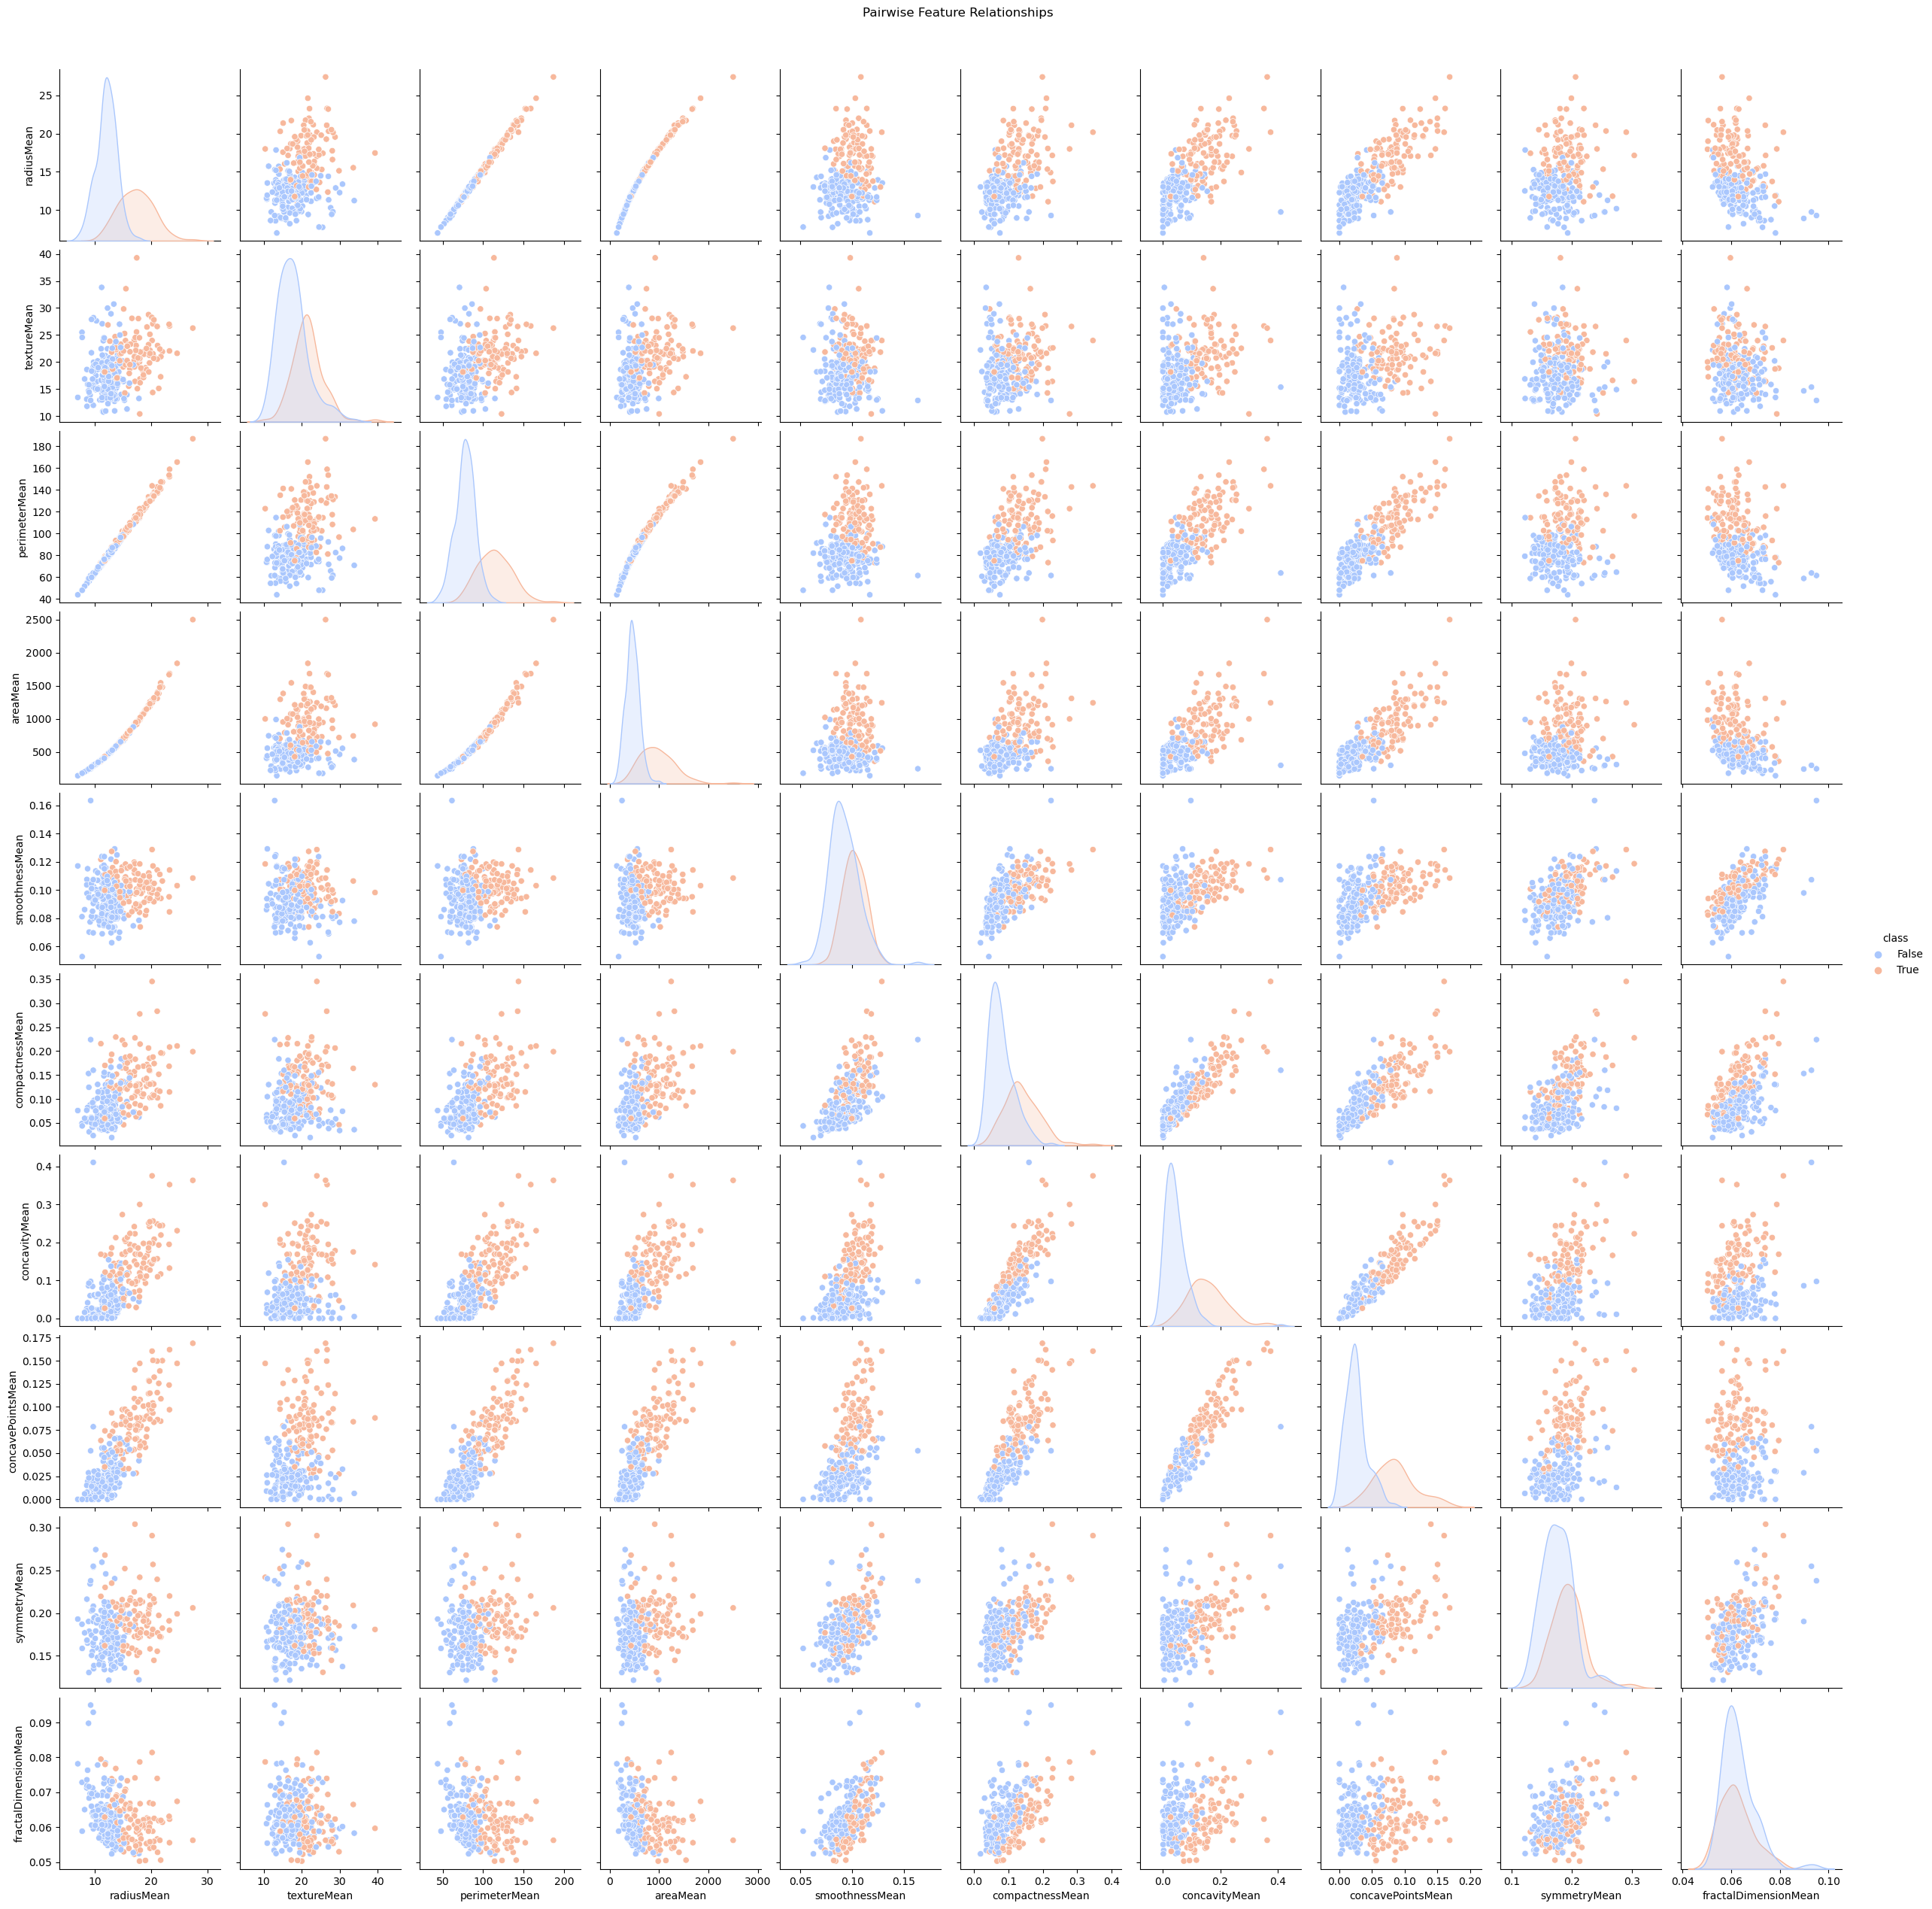

In [14]:
mean_cols = [col for col in training_df.columns if col.endswith('Mean')]
sns.pairplot(training_df[mean_cols + ['class']], hue='class', palette='coolwarm', diag_kind='kde')
plt.suptitle('Pairwise Feature Relationships', y=1.02)
plt.show()

**Observations**

1. High overlap between points of both classes 
    - features alone are not enough to classify tumors reliably
    - e.g. fractalDimensionMean <-> symmetryMean
2. Class separation 
    - features have strong predictive power
    - e.g. concavityMean <-> concavePointsMean
3. Correlations = straight diagonal pattern
    - e.g. radiusMean <-> perimeterMean
4. Outliers

## 3 Data Cleaning
We now start cleaning the data in the training dataset. 

In [15]:
training_df_cleaned = training_df.copy()

### 3.1 Identify Target

In [16]:
TARGET = 'class'
if TARGET not in training_df_cleaned.columns:
    raise ValueError(f"Target column '{TARGET}' not found in training dataframe.")

TARGET

'class'

### 3.2 Drop non-predictive values

We will drop `ID` because it is non-predictive.

In [17]:

if 'ID' in training_df_cleaned.columns:
    training_df_cleaned = training_df_cleaned.drop(columns=['ID'])
print('Shape after dropping ID:', training_df_cleaned.shape)

Shape after dropping ID: (285, 31)


### 3.3 Duplication

In [18]:
shape_before = training_df_cleaned.shape[0]
training_df_cleaned = training_df_cleaned.drop_duplicates()
print('Dropped', shape_before - shape_before, 'duplicate rows. Now:', training_df_cleaned.shape)

Dropped 0 duplicate rows. Now: (285, 31)


### 3.4 Missing Values

(No missing values in dataset)

In [19]:
display(training_df_cleaned.isnull().sum().loc[lambda s: s>0])

Series([], dtype: int64)

### 3.5 Outlier

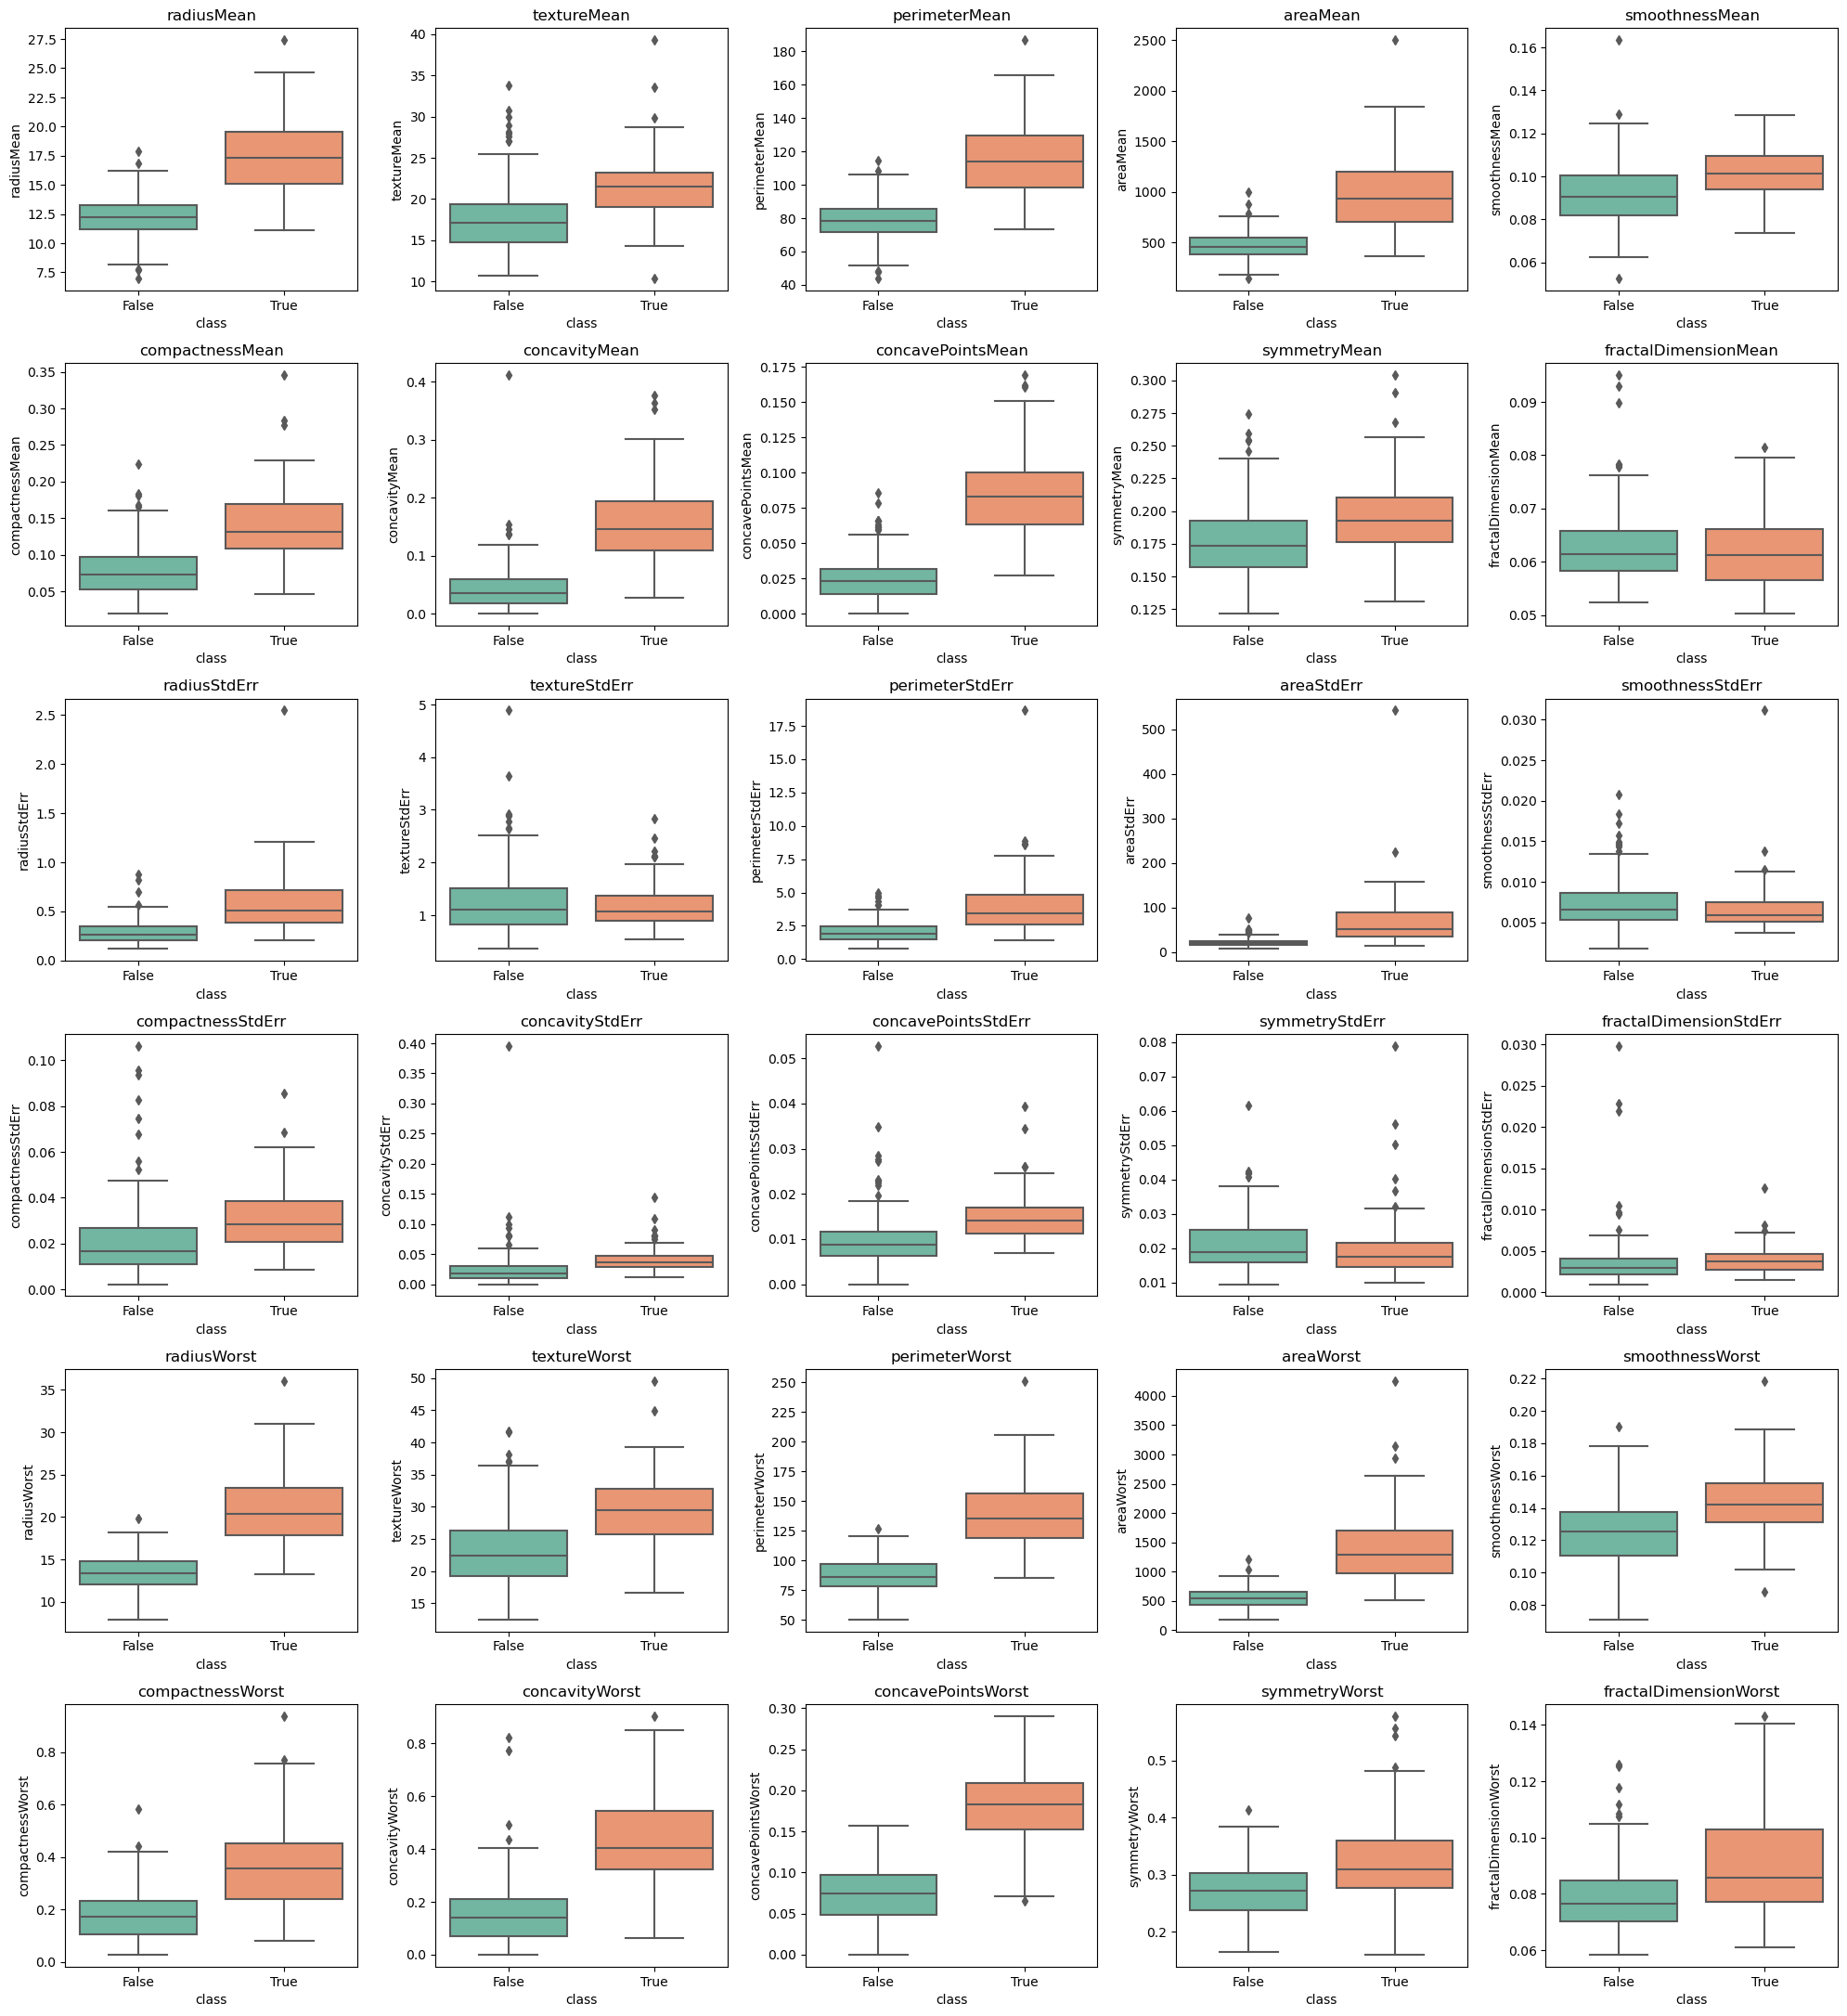

In [20]:
numeric_cols = training_df_cleaned.select_dtypes(include=['float64', 'int64']).columns.tolist()
if 'class' in numeric_cols:
    numeric_cols.remove('class')
    
plt.figure(figsize=(20, 25))
for i, col in enumerate(training_df_cleaned[numeric_cols]):
    plt.subplot(7, 5, i+1)
    sns.boxplot(x='class', y=training_df_cleaned[col], data=training_df_cleaned, palette='Set2')
    plt.title(col)
plt.tight_layout()
plt.show()

In [21]:
def remove_outliers(df, lower_q, upper_q):
    df_clean = df.copy()
    numeric_cols = df_clean.select_dtypes(include='number').columns
    
    lower_bounds = df_clean[numeric_cols].quantile(lower_q)
    upper_bounds = df_clean[numeric_cols].quantile(upper_q)
    
    mask = ((df_clean[numeric_cols] >= lower_bounds) & (df_clean[numeric_cols] <= upper_bounds)).all(axis=1)
    df_filtered = df_clean[mask]
    
    return df_filtered

### 3.6 Correlation 

- Compute correlation matrix and display as a heatmap.
- Function to remove highly correlated/redundant features

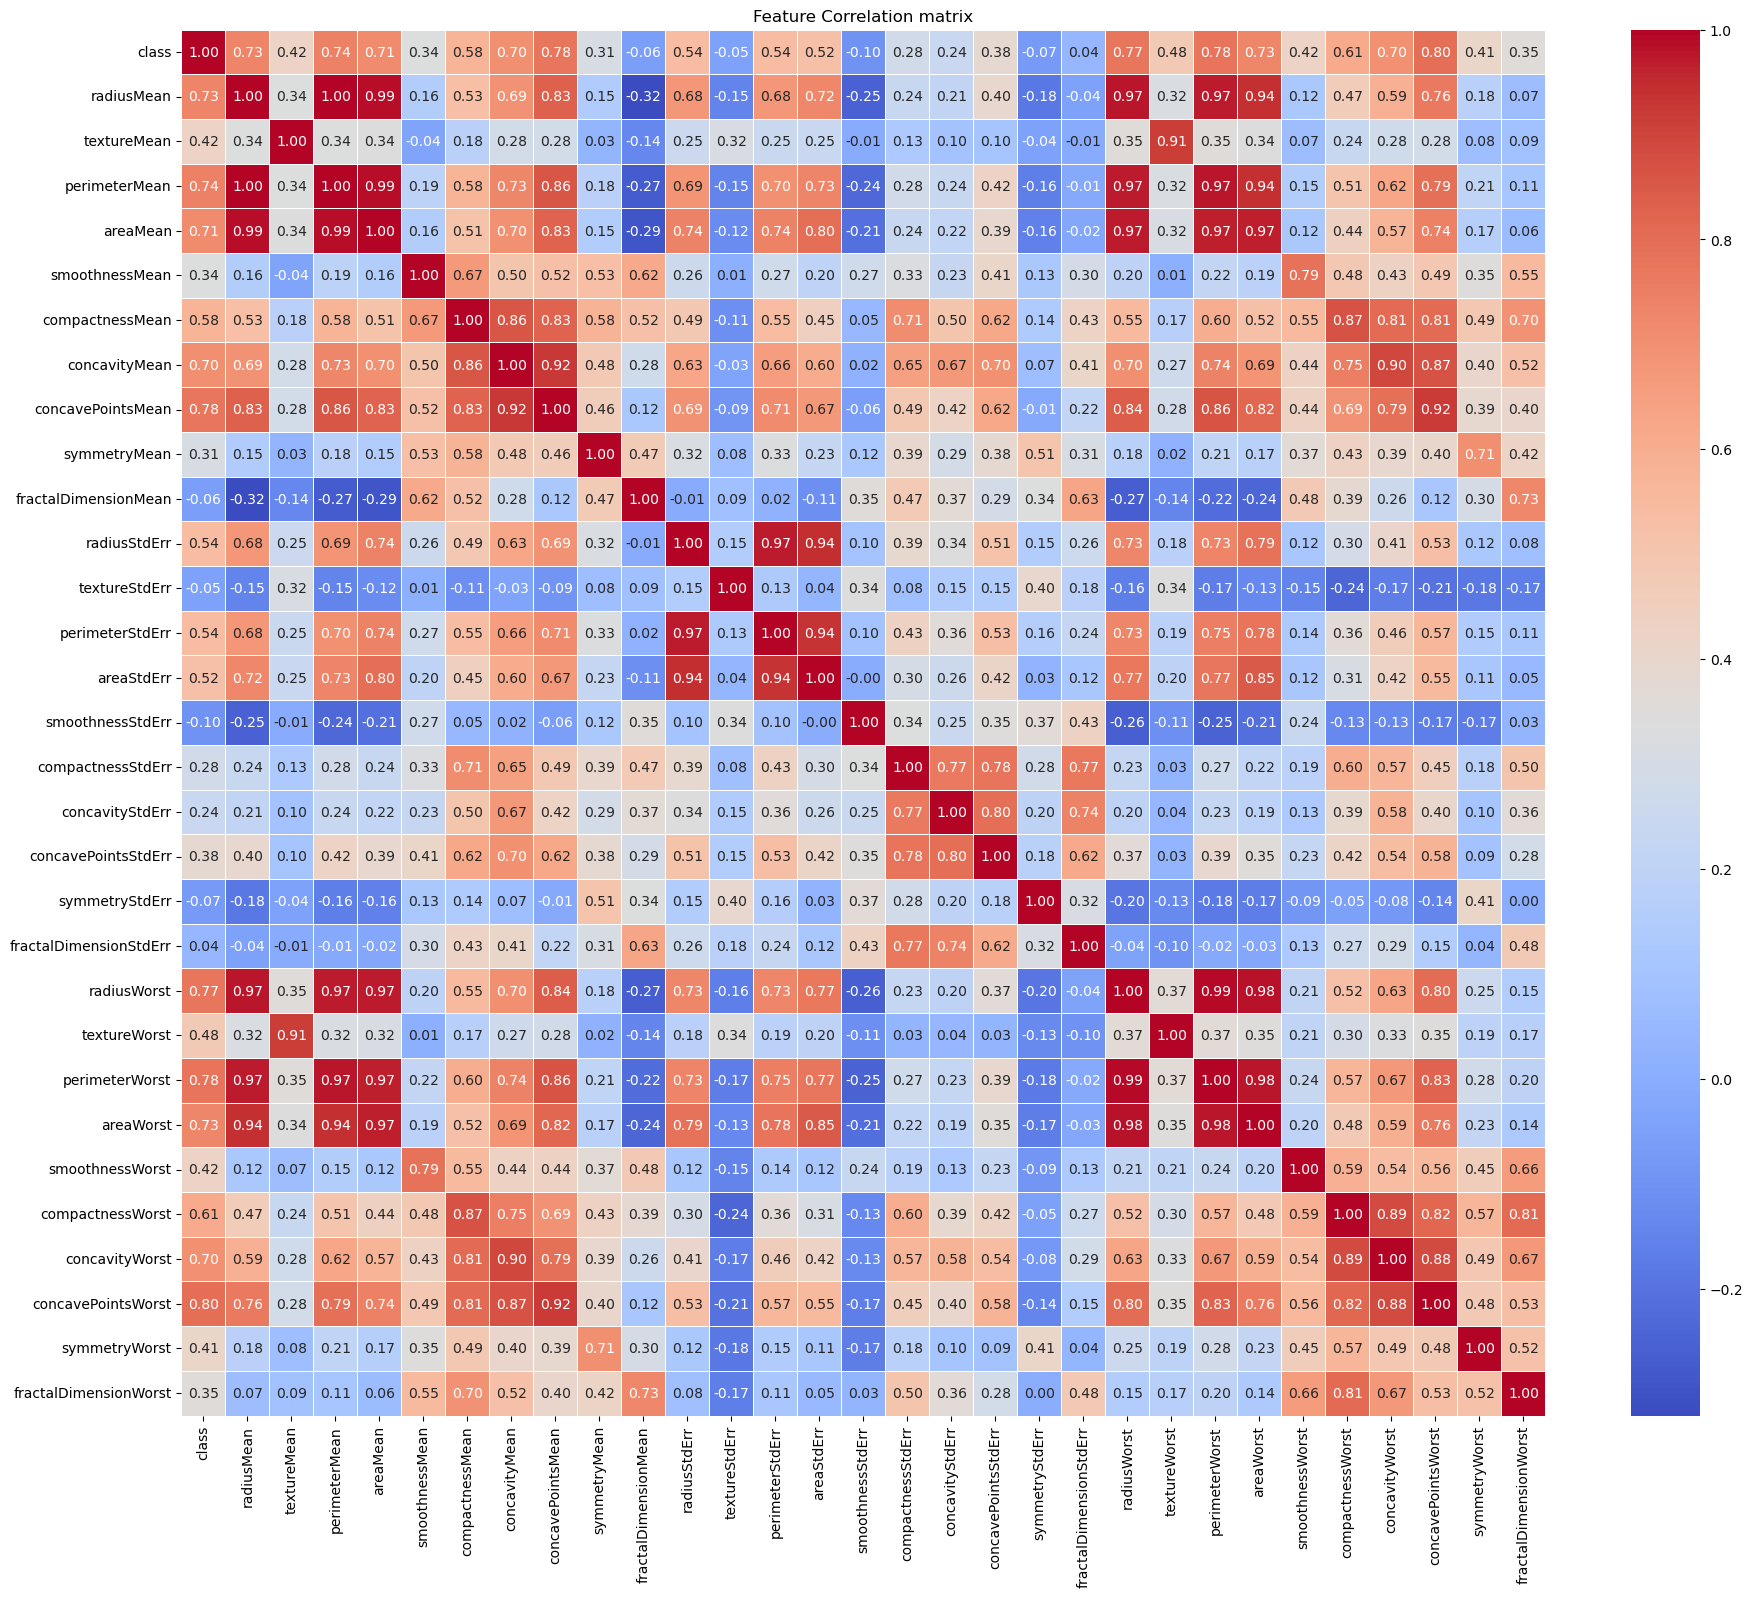

radiusMean      perimeterMean      0.997917
radiusWorst     perimeterWorst     0.994108
radiusMean      areaMean           0.986544
perimeterMean   areaMean           0.985754
radiusWorst     areaWorst          0.982171
perimeterWorst  areaWorst          0.976889
perimeterMean   perimeterWorst     0.974502
radiusMean      radiusWorst        0.974413
perimeterMean   radiusWorst        0.974166
radiusStdErr    perimeterStdErr    0.972245
areaMean        radiusWorst        0.971577
radiusMean      perimeterWorst     0.969640
areaMean        areaWorst          0.968140
                perimeterWorst     0.967910
radiusStdErr    areaStdErr         0.944433
dtype: float64

In [22]:
corr = training_df_cleaned.corr(numeric_only=True)

plt.figure(figsize=(22, 18))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation matrix')
plt.show()

corr_abs = corr.abs()
np.fill_diagonal(corr_abs.values, 0)
high_corr = (corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(bool))
             .stack().sort_values(ascending=False))
display(high_corr.head(15))

In [23]:
def drop_highly_correlated_features(df, threshold):
    df_copy = df.copy()
    numeric_cols = df_copy.select_dtypes(include='number').columns

    if len(numeric_cols) == 0:
        return df_copy

    corr_matrix = df_copy[numeric_cols].corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    df_filtered = df_copy.drop(columns=to_drop)
    return df_filtered, to_drop

## 4 Feature Engineering

Add engineered features to improve model performance. \
Additional features are calculated from existing measurements.

In [24]:
training_df_eng = training_df_cleaned.copy()

In [25]:
def add_engineered_features(df):
    df = df.copy()
    
    # basic ratios
    df['area_perimeter_ratio'] = df['areaMean'] / (df['perimeterMean'] + 1e-5)
    df['concavity_concavePoints_ratio'] = df['concavityMean'] / (df['concavePointsMean'] + 1e-5)
    df['texture_smoothness_ratio'] = df['textureMean'] / (df['smoothnessMean'] + 1e-5)
    df['perimeter_radius_ratio'] = df['perimeterMean'] / (df['radiusMean'] + 1e-5)
    df['smoothness_compactness_ratio'] = df['smoothnessMean'] / (df['compactnessMean'] + 1e-5)
    
    # mean-to-worst ratios and differences
    features = ["radius", "texture", "perimeter", "area", "smoothness",
                "compactness", "concavity", "concavePoints", "symmetry", "fractalDimension"]
    
    for f in features:
        df[f'{f}_worst_to_mean'] = df[f'{f}Worst'] / (df[f'{f}Mean'] + 1e-5)
        df[f'{f}_mean_to_std'] = df[f'{f}Mean'] / (df[f'{f}StdErr'] + 1e-5)
        df[f'{f}_worst_minus_mean'] = df[f'{f}Worst'] - df[f'{f}Mean']
    
    # shape / geometry features
    df['circularity_index'] = (4 * np.pi * df['areaMean']) / ((df['perimeterMean'] ** 2) + 1e-5)
    df['roughness_index'] = (df['perimeterWorst'] / (df['perimeterMean'] + 1e-5)) - 1
    df['area_variability_index'] = (df['areaWorst'] - df['areaMean']) / (df['areaStdErr'] + 1e-5)
    
    # composite feature groups
    df['size_index'] = df[['radiusMean', 'perimeterMean', 'areaMean']].mean(axis=1)
    df['structure_index'] = df[['smoothnessMean', 'compactnessMean', 'concavityMean', 'concavePointsMean']].mean(axis=1)
    
    # optional interaction features
    df['radius_texture_interaction'] = df['radiusMean'] * df['textureMean']
    df['smoothness_compactness_interaction'] = df['smoothnessMean'] * df['compactnessMean']
    df['concavity_points_interaction'] = df['concavityMean'] * df['concavePointsMean']
    
    return df

training_df_eng = add_engineered_features(training_df_eng)
print('Shape after feature engineering:', training_df_eng.shape)
training_df_eng.head()

Shape after feature engineering: (285, 74)


class  radiusMean  textureMean  perimeterMean  areaMean  smoothnessMean  \
0  False       13.27        17.02          84.55     546.4         0.08445   
1  False       12.06        18.90          76.66     445.3         0.08386   
2  False       13.71        18.68          88.73     571.0         0.09916   
3   True       11.80        16.58          78.99     432.0         0.10910   
4   True       18.03        16.85         117.50     990.0         0.08947   

   compactnessMean  concavityMean  concavePointsMean  symmetryMean  ...  \
0          0.04994        0.03554           0.024560        0.1496  ...   
1          0.05794        0.00751           0.008488        0.1555  ...   
2          0.10700        0.05385           0.037830        0.1714  ...   
3          0.17000        0.16590           0.074150        0.2678  ...   
4          0.12320        0.10900           0.062540        0.1720  ...   

   fractalDimension_mean_to_std  fractalDimension_worst_minus_mean  \
0                     22.641660                            0.01949   
1                     21.881331                            0.02035   
2                     18.214001                            0.02188   
3                     15.868676                            0.02929   
4                     23.630417                            0.02445   

   circularity_index  roughness_index  area_variability_index  size_index  \
0           0.960491         0.169012                6.580224  214.740000   
1           0.952193         0.128881                6.509430  178.006667   
2           0.911392         0.120590                4.948958  224.480000   
3           0.870060         0.163818                6.460353  174.263333   
4           0.901092         0.134468                8.442827  375.176667   

   structure_index  radius_texture_interaction  \
0         0.048623                    225.8554   
1         0.039449                    227.9340   
2         0.074460                    256.1028   
3         0.129788                    195.6440   
4         0.096052                    303.8055   

   smoothness_compactness_interaction  concavity_points_interaction  
0                            0.004217                      0.000873  
1                            0.004859                      0.000064  
2                            0.010610                      0.002037  
3                            0.018547                      0.012301  
4                            0.011023                      0.006817  

[5 rows x 74 columns]

## 5 Preprocessing Pipeline

In [26]:
def build_preprocessing_pipeline(
    features,
    scaling = True,
    scaler = StandardScaler()
):    
    if not scaling:
        return None
    
    pipeline = Pipeline([('scaler', scaler)])
    
    return ColumnTransformer(
        transformers=[('numeric', pipeline, features)],
        remainder='drop',
        verbose_feature_names_out=False
    )

## 6 Model Training & Evaluation

In [27]:
df = training_df_cleaned.copy()

# with engineered features
# df = training_df_eng.copy()

### 6.1 Target Preparation

In [28]:
if 'class' in df.columns:
    if df['class'].dtype == 'bool':
        df['class'] = df['class'].astype(int)
        print("Converted boolean target to integers. Unique values:", df['class'].unique())
    else:
        unique_vals = df['class'].dropna().unique()
        if set(map(str, unique_vals)) <= {'True','False','true','false'}:
            df['class'] = df['class'].astype(str).str.lower().map({'false':0,'true':1}).astype(float).astype('Int64')
            print('Mapped textual booleans to 0/1. Unique values now:', df['class'].unique())
        else:
            print('Target dtype:', df['class'].dtype, 'unique values (sample):', unique_vals[:10])

Converted boolean target to integers. Unique values: [0 1]


### 6.2 Split dataset

In [29]:
def tt_split(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = 0.1, random_state = 42, shuffle = True
    )
    return X_train, X_test, y_train, y_test

X = df.drop(columns=[TARGET])
y = df[TARGET]

X_train, X_test, y_train, y_test = tt_split(X, y)
print('Training set shape:', X_train.shape)
print('Test set shape:', X_test.shape)

Training set shape: (256, 30)
Test set shape: (29, 30)


### 6.3 Classifier

- Random Forest 
- XGBoost (Gradient Boosting)
- KNN (Logistic Regression)

In [30]:
from classifierConfigs import (
    get_knn_classifiers,
    get_rf_classifiers,
    get_xgb_classifiers,
)

classifiers = [
    {'name': 'KNN', 'configs': get_knn_classifiers()},
    {'name': 'Random Forest', 'configs': get_rf_classifiers()},
    {'name': 'XG Boost', 'configs': get_xgb_classifiers(task='binary')},
]

print("Number of different classifier parameter settings:")
for clf in classifiers:
    print(f"    - {clf['name']}: {len(clf['configs'])}")

Number of different classifier parameter settings:
    - KNN: 16
    - Random Forest: 12
    - XG Boost: 48


### 6.4 Configurations

In [31]:
scaling_options = [False, 'Standard', 'MinMax']
outlier_q = [-1, 0.01, 0.05]
correlation_threshold = [-1, 0.9, 0.95]

preprocessing_configs = [
    {
        "name": f"Outlier-Quantile: {'None' if q == -1 else q} + Correlation-Threshold: {'None' if corr_threshold == -1 else corr_threshold } + Scaling: {scale}",
        "scaling": scale,
        "outlier_q": q,
        "correlation_threshold": corr_threshold,
    }
    for scale in scaling_options
    for q in outlier_q
    for corr_threshold in correlation_threshold
]

print(f"{len(preprocessing_configs)} preprocessing configs")

27 preprocessing configs


### 6.5 Evaluation Metrics Setup

We use following metrics:
- Accuracy 
- Precision
- Recall 
- F1
- Confusion matrix

In [32]:
from classifierConfigs import (get_scorings)

scoring = get_scorings(multiclass=False)
refit_metric = "f1_macro"

def evaluate_model(y_true, y_pred):
    results = {}
    results['accuracy'] = accuracy_score(y_true, y_pred)
    results['precision'] = precision_score(y_true, y_pred, zero_division=0)
    results['recall'] = recall_score(y_true, y_pred, zero_division=0)
    results['f1'] = f1_score(y_true, y_pred, zero_division=0)
    results['balanced_accuracy'] = balanced_accuracy_score(y_true, y_pred)
    
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    
    return results, report, cm

### 6.6 Train Models

Loop iterations - first approach. No longer used.

In [33]:
import os
import json 
from datetime import datetime

results_dir = 'breast-cancer/results'
os.makedirs(results_dir, exist_ok=True)

def train_models(
    X_train, X_test, y_train, y_test,
    preprocessing_configs=preprocessing_configs,
    classifiers=classifiers,
    base_filename='training-results'
):
    full_results = {}
    summary_rows = []
    
    for pi, prep_config in enumerate(preprocessing_configs):
        X_train_cp = X_train.copy()
        X_test_cp = X_test.copy()
        y_train_cp = y_train.copy()
        y_test_cp = y_test.copy()
        
        prep_name = prep_config['name']
        print(f"\nStart training for preprocessing config: {prep_config['name']}")
        
        if prep_config['outlier_q'] != -1:
            X_train_cp = remove_outliers(X_train_cp, prep_config['outlier_q'], 1-prep_config['outlier_q'])
            X_test_cp = remove_outliers(X_test_cp, prep_config['outlier_q'], 1-prep_config['outlier_q'])
            y_train_cp = y_train.loc[X_train_cp.index]
            y_test_cp = y_test.loc[X_test_cp.index]
            
        if prep_config['correlation_threshold'] != -1:
            X_train_cp, to_drop = drop_highly_correlated_features(X_train_cp, prep_config['correlation_threshold'])
            X_test_cp = X_test_cp.drop(columns=to_drop)
        
        X_test_cp = X_test_cp[X_train_cp.columns]

        scaling_options = prep_config['scaling']
        base_preprocessor = build_preprocessing_pipeline(
            features=X_train_cp.columns,
            scaling=False if scaling_options is False else True,
            scaler=StandardScaler() if scaling_options == 'Standard' else (
                    MinMaxScaler() if scaling_options == 'MinMax' else None)
        )
        
        full_results[prep_name] = {}
        
        for classifier in classifiers:
            classifier_name = classifier['name']
            classifier_configs = classifier['configs']
            print(f"    - Start training for {classifier_name}")
            print(f"        - Number of configurations: {len(classifier_configs)}")
            
            full_results[prep_name][classifier_name] = []
            
            for i, clf in enumerate(classifier_configs):
                classifier = clone(clf)
                
                if base_preprocessor is None:
                    pipeline = Pipeline([
                        ('classifier', classifier)
                    ])
                else:
                    preprocessor = clone(base_preprocessor)
                    pipeline = Pipeline([
                        ('preprocesser', preprocessor),
                        ('classifier', classifier)
                    ])

                pipeline.fit(X_train_cp, y_train_cp)
                
                y_pred_train = pipeline.predict(X_train_cp)
                y_pred_test = pipeline.predict(X_test_cp)
                
                train_metrics, train_report, train_cm = evaluate_model(
                    y_train_cp, y_pred_train
                )
                test_metrics, test_report, test_cm = evaluate_model(
                    y_test_cp, y_pred_test
                )
                
                res = {
                    'pipeline': pipeline,
                    'preprocessing_idx': pi,
                    'train_metrics': train_metrics,
                    'test_metrics': test_metrics,
                    'train_report': train_report,
                    'test_report': test_report,
                    'train_cm': train_cm,
                    'test_cm': test_cm,
                    'preprocessing_config': {
                        'preprocessor': str(base_preprocessor),
                    },
                    'model_config': str(clf)
                }
                full_results[prep_name][classifier_name].append(res)
                
                summary_rows.append({
                    'preprocessing_idx': pi,
                    'group': classifier_name,
                    'model_idx': i,
                    'Train Accuracy': train_metrics['accuracy'],
                    'Test Accuracy': test_metrics['accuracy'],
                    'Train Balanced Accuracy': train_metrics['balanced_accuracy'],
                    'Test Balanced Accuracy': test_metrics['balanced_accuracy'],
                    'Train Precision': train_metrics['precision'],
                    'Test Precision': test_metrics['precision'],
                    'Train Recall': train_metrics['recall'],
                    'Test Recall': test_metrics['recall'],
                    'Train F1': train_metrics['f1'],
                    'Test F1': test_metrics['f1'],
                    'n_train': X_train_cp.shape[0],
                    'n_test': X_test_cp.shape[0]
                })
                
    summary_df = pd.DataFrame(summary_rows)
    
    safe_results = {}
    for k, v in full_results.items():
        safe_results[k] = {kk: [{mk: mv for mk, mv in run.items() if mk != 'pipeline'} for run in vv] for kk, vv in v.items()}

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    with open(f'{results_dir}/{base_filename}_{timestamp}.json', "w") as f:
        json.dump(safe_results, f, indent=4, default=str)
    
    return summary_df, full_results

In [ ]:
def best_per_preproc_classifier_from_summary(summary_df, metric='test_ball_acc', ascending=False, top_n=1):
    """
    summary_df: DataFrame with at least columns
      ['preprocessor','group','model_idx','model_repr','test_f1','test_acc','test_roc_auc','cv_acc_mean','fit_time_s']
    metric: metric column to pick best by (default 'test_f1')
    ascending: whether smaller is better (default False)
    top_n: if >1, returns top_n per group-preproc instead of 1
    """
    df = summary_df.copy()
    required_cols = ['preprocessing_idx', 'group']
    for c in required_cols:
        if c not in df.columns:
            raise ValueError(f"summary_df missing required column: {c}")

    df_sorted = df.sort_values(by=['preprocessing_idx','group', metric], ascending=[True, True, ascending])

    best = df_sorted.groupby(['preprocessing_idx','group']).head(top_n).reset_index(drop=True)
    cols_to_show = ['preprocessing_idx','group','model_idx','Train Accuracy','Test Accuracy','Train Balanced Accuracy','Test Balanced Accuracy','Train Precision','Test Precision','Train F1', 'Test F1']
    existing = [c for c in cols_to_show if c in best.columns]
    return best[existing]

In [ ]:
# summary_df, full_results = train_models(X_train, X_test, y_train, y_test)

# best_table = best_per_preproc_classifier_from_summary(summary_df, metric='Test Balanced Accuracy')
# display(best_table.sort_values(by=['Test F1'], ascending=False))

## 7 GridSearch & Evaluation

- Train models using GridSearch (different hyperparameters)
- Compare results
- Results visualization
- K-fold cross validation ?

### 7.1 Find best Hyperparameters

In [36]:
import importlib
import os 
import classifierConfigs as cc
importlib.reload(cc)
from classifierConfigs import get_classifier_configs, get_scorings

scoring = get_scorings(multiclass=False)
refit_metric = "f1"
configs = get_classifier_configs(task='binary')

results_dir = "breast-cancer/gridsearch"
os.makedirs(results_dir, exist_ok=True)
all_results = []

for pidx, prep_config in enumerate(preprocessing_configs):
    print(f"{pidx}/{len(preprocessing_configs)}: {prep_config['name']}")
    for name, cfg in configs.items():
        print(f"Running Grid Search for {name}...")
        
        X_train_cp = X_train.copy()
        X_test_cp = X_test.copy()
        y_train_cp = y_train.copy()
        y_test_cp = y_test.copy()
        
        if prep_config['outlier_q'] != -1:
            X_train_cp = remove_outliers(X_train_cp, prep_config['outlier_q'], 1-prep_config['outlier_q'])
            X_test_cp = remove_outliers(X_test_cp, prep_config['outlier_q'], 1-prep_config['outlier_q'])
            y_train_cp = y_train.loc[X_train_cp.index]
            y_test_cp = y_test.loc[X_test_cp.index]
            
        if prep_config['correlation_threshold'] != -1:
            X_train_cp, to_drop = drop_highly_correlated_features(X_train_cp, prep_config['correlation_threshold'])
            X_test_cp = X_test_cp.drop(columns=to_drop)
        
        X_test_cp = X_test_cp[X_train_cp.columns]

        scaling_options = prep_config['scaling']
        base_preprocessor = build_preprocessing_pipeline(
            features=X_train_cp.columns,
            scaling=False if scaling_options is False else True,
            scaler=StandardScaler() if scaling_options == 'Standard' else (
                    MinMaxScaler() if scaling_options == 'MinMax' else None)
        )
        
        pipe = Pipeline(steps=[
            ('preprocessor', base_preprocessor),
            ('classifier', cfg['model'])
        ])        

        param_grid = {f'classifier__{k}': v for k, v in cfg['param_grid'].items()}

        gs = GridSearchCV(
            estimator=pipe,
            param_grid=param_grid,
            scoring=scoring,
            refit=refit_metric,
            n_jobs=6,
            verbose=3,
            cv=3
        )

        gs.fit(X_train_cp, y_train_cp)

        # Save per-model CV results
        res_df = pd.DataFrame(gs.cv_results_)
        rank_col = f'rank_test_{refit_metric}' if f'rank_test_{refit_metric}' in res_df.columns else ('rank_test_score' if 'rank_test_score' in res_df.columns else None)
        if rank_col is not None:
            res_df = res_df.sort_values(rank_col)
        res_df.insert(0, 'model', name)
        res_df.insert(1, 'scoring', refit_metric)
        res_df['prep_name'] = prep_config['name']
        out_path = os.path.join(results_dir, f"{name.replace(' ', '_')}_cv_results_{refit_metric}.csv")
        res_df.to_csv(out_path, index=False)
        all_results.append(res_df)

        print(f"Best parameters for {name}: {gs.best_params_} | Best {refit_metric}: {gs.best_score_:.4f}")

        y_val_pred = gs.predict(X_test_cp).astype(bool)

        print(f"Validation Classification Report for {name}:\n")
        print(classification_report(y_test_cp, y_val_pred, zero_division=0))
        print("-" * 80)

if all_results:
    pd.concat(all_results, ignore_index=True).to_csv(
        os.path.join(results_dir, f"ALL_cv_results_9010_not_engineered.csv"),
        index=False
    )

0/27: Outlier-Quantile: None + Correlation-Threshold: None + Scaling: False
Running Grid Search for KNN...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END classifier__n_neighbors=2, classifier__p=1, classifier__weights=uniform; accuracy: (test=0.907) f1: (test=0.862) precision: (test=0.962) recall: (test=0.781) total time=   0.1s
[CV 3/3] END classifier__n_neighbors=2, classifier__p=1, classifier__weights=uniform; accuracy: (test=0.918) f1: (test=0.877) precision: (test=0.962) recall: (test=0.806) total time=   0.1s
[CV 2/3] END classifier__n_neighbors=2, classifier__p=1, classifier__weights=uniform; accuracy: (test=0.906) f1: (test=0.852) precision: (test=1.000) recall: (test=0.742) total time=   0.1s
[CV 1/3] END classifier__n_neighbors=2, classifier__p=2, classifier__weights=uniform; accuracy: (test=0.884) f1: (test=0.833) precision: (test=0.893) recall: (test=0.781) total time=   0.0s
[CV 2/3] END classifier__n_neighbors=2, classifier__p=2, classifier__wei

In [ ]:
results_dir = "breast-cancer/gridsearch"
file = "ALL_cv_results_8020_engineered.csv"
file = "ALL_cv_results_9010_not_engineered.csv"
file = "ALL_cv_results_8020_not_engineered.csv"
all_results = pd.read_csv(os.path.join(results_dir, file))
all_results["params"].iloc[0]

"{'classifier__n_neighbors': 2, 'classifier__p': 1, 'classifier__weights': 'distance'}"

In [55]:
print(all_results.shape)
randomForest_results = all_results[all_results['model'] == 'Random Forest'].sort_values(by='mean_test_f1', ascending=False)
XGBoost_results = all_results[all_results['model'] == 'XGBoost'].sort_values(by='mean_test_f1', ascending=False)
KNN_results = all_results[all_results['model'] == 'KNN'].sort_values(by='mean_test_f1', ascending=False)

(2052, 38)


### 7.2 Evaluate Effects of Preprocessing Configurations

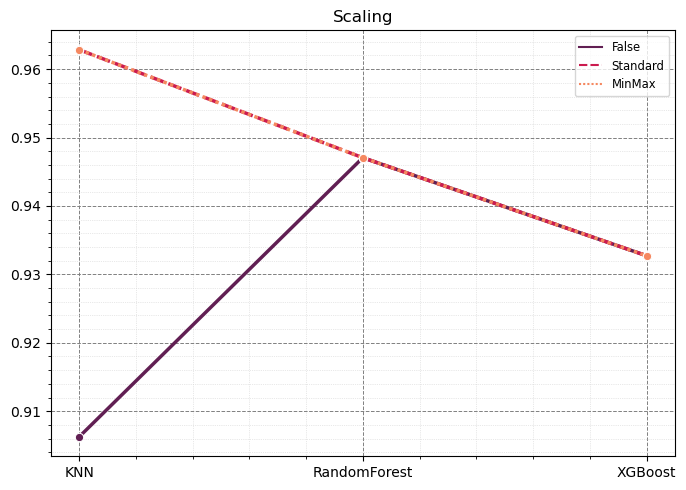

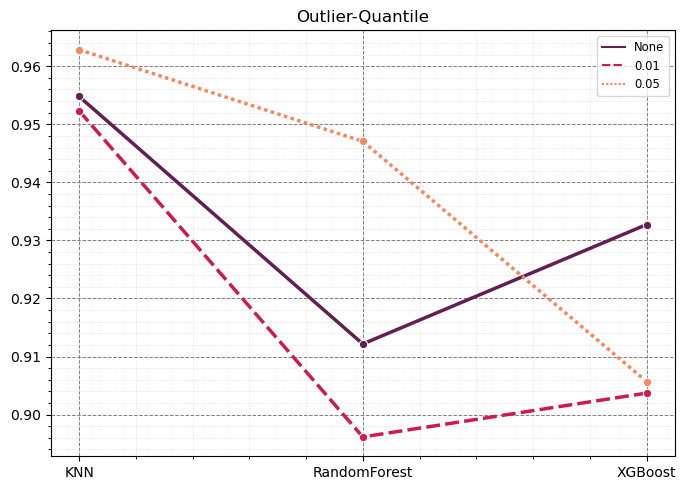

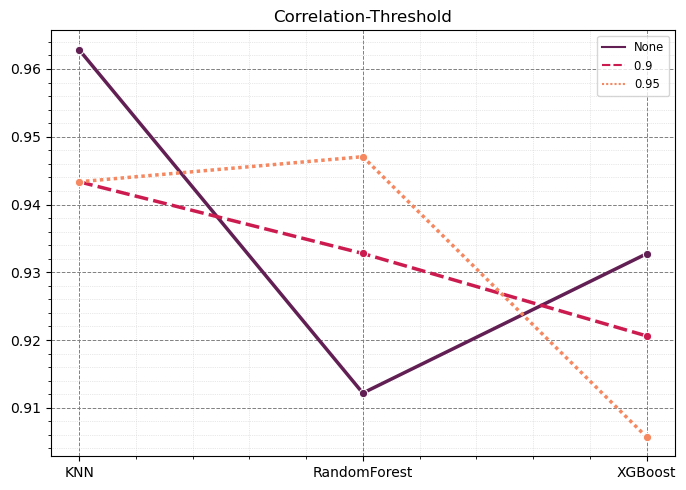

In [56]:
def best_row_for_config(df, search_str):
    mask = df['prep_name'].astype(str).str.contains(search_str, case=False, na=False)
    sub = df[mask].copy()
    return sub[sub['rank_test_f1'] == 1].iloc[0]

def plot_prep_config_effect_lines(KNN_results, RF_results, XGB_results, config,options):
    dfs = {
        'KNN': KNN_results,
        'RandomForest': RF_results,
        'XGBoost': XGB_results
    }
    metric_display_name='Test F1'

    records = []
    for clf_name, df in dfs.items():
        for option in options:
            best = best_row_for_config(df, f'{config}: {option}')
            if best is not None:
                score_col = 'mean_test_f1'
                score = float(best[score_col]) if score_col in best else np.nan
            else:
                score = np.nan
            records.append({
                'option': option.replace(f'{config}: ', ''),
                'classifier': clf_name,
                metric_display_name: score
            })

    result_df = pd.DataFrame(records)

    result_df['option'] = pd.Categorical(result_df['option'], categories=options, ordered=True)

    plt.figure(figsize=(7,5))
    ax = sns.lineplot(
        data=result_df,
        x='classifier',
        y=metric_display_name,
        hue='option',
        style='option',
        marker='o',
        linewidth=2.5,
        palette=sns.color_palette("rocket", len(options))
    )

    ax.legend(title='', fontsize='small', title_fontsize='small', loc='best')
    
    ax.grid(True, which='major', color='gray', linestyle='--', linewidth=0.7)
    ax.grid(True, which='minor', color='lightgray', linestyle=':', linewidth=0.5)
    ax.minorticks_on()
    
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.title(config)
    plt.tight_layout()
    plt.savefig(f"preprocessing-effect-{config}.png")
    plt.show()

plot_prep_config_effect_lines(KNN_results, randomForest_results, XGBoost_results, 'Scaling', ['False', 'Standard', 'MinMax'])
plot_prep_config_effect_lines(KNN_results, randomForest_results, XGBoost_results, 'Outlier-Quantile', ['None', '0.01', '0.05'] )
plot_prep_config_effect_lines(KNN_results, randomForest_results, XGBoost_results, 'Correlation-Threshold', ['None', '0.9 ', '0.95'])

### 7.3 Evaluate Effects of Hyperparameters

In [57]:
randomForest_params = ["param_classifier__n_estimators", "param_classifier__max_depth"]
XGBoost_params = ["param_classifier__n_estimators", "param_classifier__max_depth", "param_classifier__learning_rate"]
KNN_params = ["param_classifier__n_neighbors", "param_classifier__weights", "param_classifier__p"]

In [58]:
randomForest_best = randomForest_results.loc[randomForest_results['rank_test_f1'] == 1].iloc[0]
randomForest_best_params = {
    'n_estimators': randomForest_best['param_classifier__n_estimators'].astype(int),
    'max_depth': randomForest_best['param_classifier__max_depth'].astype(int)
}
XGBoost_best = XGBoost_results.loc[XGBoost_results['rank_test_f1'] == 1].iloc[0]
XGBoost_best_params = {
    'n_estimators': XGBoost_best['param_classifier__n_estimators'].astype(int),
    'max_depth': XGBoost_best['param_classifier__max_depth'].astype(int),
    'learning_rate': XGBoost_best['param_classifier__learning_rate']
}
KNN_best = KNN_results.loc[KNN_results['rank_test_f1'] == 1].iloc[0]
KNN_best_params = {
    'n_neighbors': KNN_best['param_classifier__n_neighbors'].astype(int),
    'weights': KNN_best['param_classifier__weights'],
    'p': KNN_best['param_classifier__p'].astype(int)
}

import matplotlib.pyplot as plt
import seaborn as sns

def plot_hyperparameter_effects(results_df, model_name, hyperparams, best_params):
    n = len(hyperparams)
    fig, axs = plt.subplots(1, n, figsize=(6 * n, 5), squeeze=False)
    axs = axs[0]

    for i, param in enumerate(hyperparams):
        ax = axs[i]
        subset = results_df.copy()
        for other_param in hyperparams:
            if other_param != param:
                subset = subset[
                    subset[other_param] == best_params[other_param.replace('param_classifier__', '')]
                ]

        sub = subset.dropna(subset=[param, 'mean_test_f1'])

        is_numeric = pd.api.types.is_numeric_dtype(sub[param])
        if not is_numeric:
            coerced = pd.to_numeric(sub[param], errors='coerce')
            if coerced.notna().sum() == len(sub):
                sub[param] = coerced
                is_numeric = True

        if is_numeric:
            sub = sub.sort_values(by=param)
            sns.lineplot(data=sub, x=param, y='mean_test_f1', marker='o', ax=ax)
        else:
            sns.barplot(data=sub, x=param, y='mean_test_f1', ax=ax)
            ax.tick_params(axis='x', rotation=45)

        clean_name = param.replace('param_classifier__', '')
        ax.set_title(clean_name)
        ax.set_xlabel(clean_name)
        if i == 0:
            ax.set_ylabel('Mean F1')
        else:
            ax.set_ylabel('')
        ax.grid(True, linestyle='--', alpha=0.4)

    fig.suptitle(f'Hyperparameter effects for {model_name}')
    fig.tight_layout()
    fig.savefig(f'hyperparameter-effects-{model_name}.png')

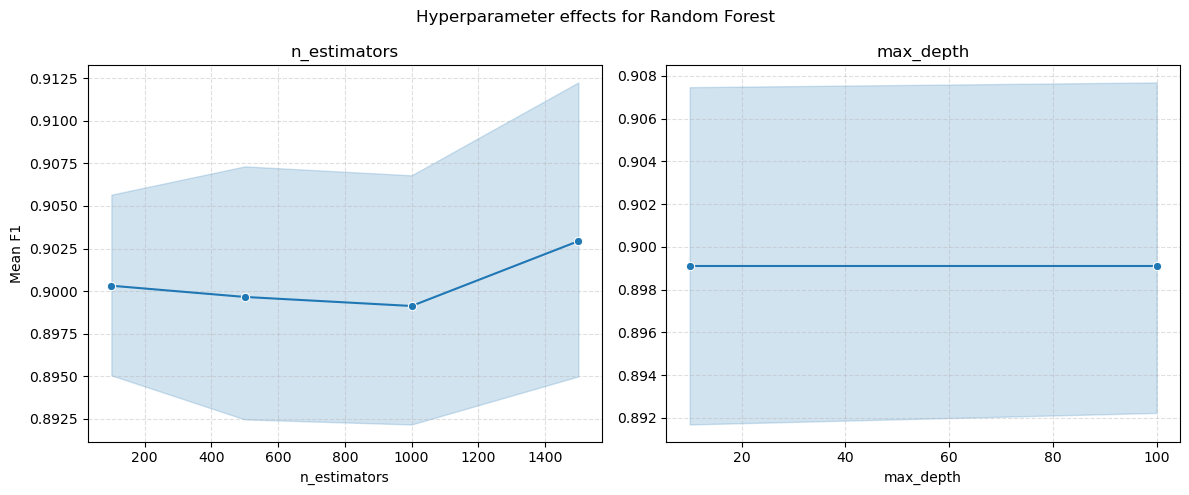

In [59]:
plot_hyperparameter_effects(randomForest_results, 'Random Forest', randomForest_params, randomForest_best_params)

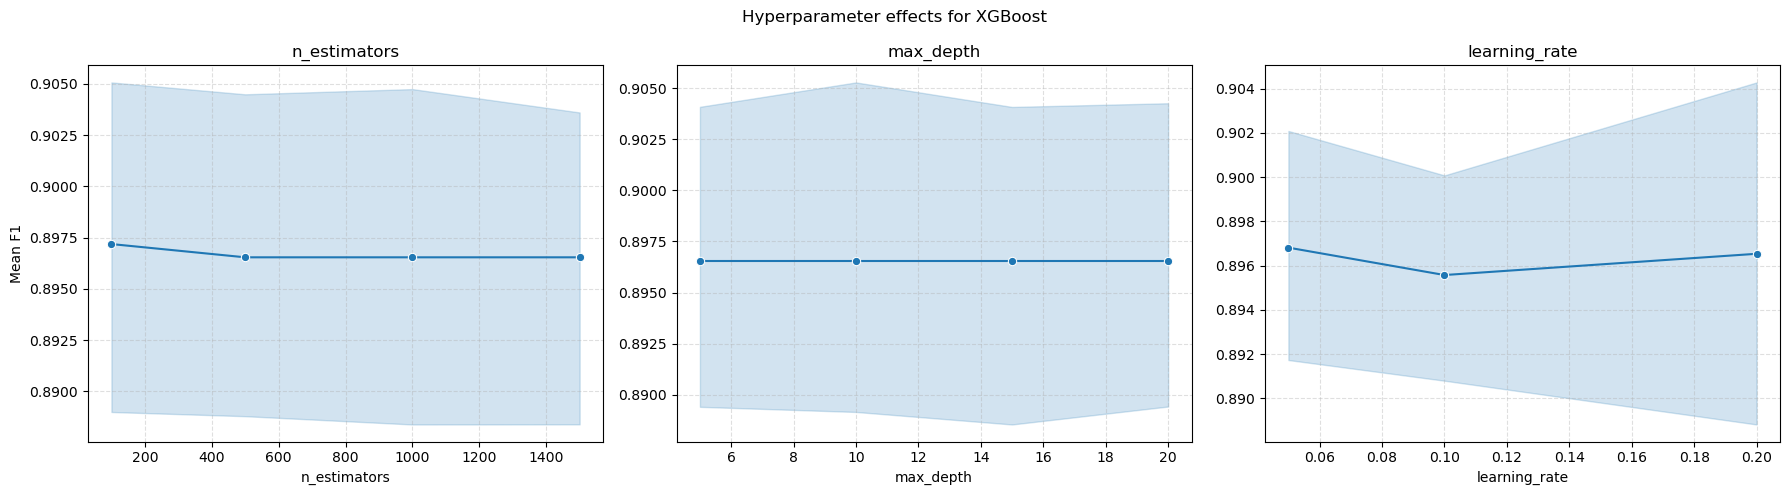

In [60]:
plot_hyperparameter_effects(XGBoost_results, 'XGBoost', XGBoost_params, XGBoost_best_params)

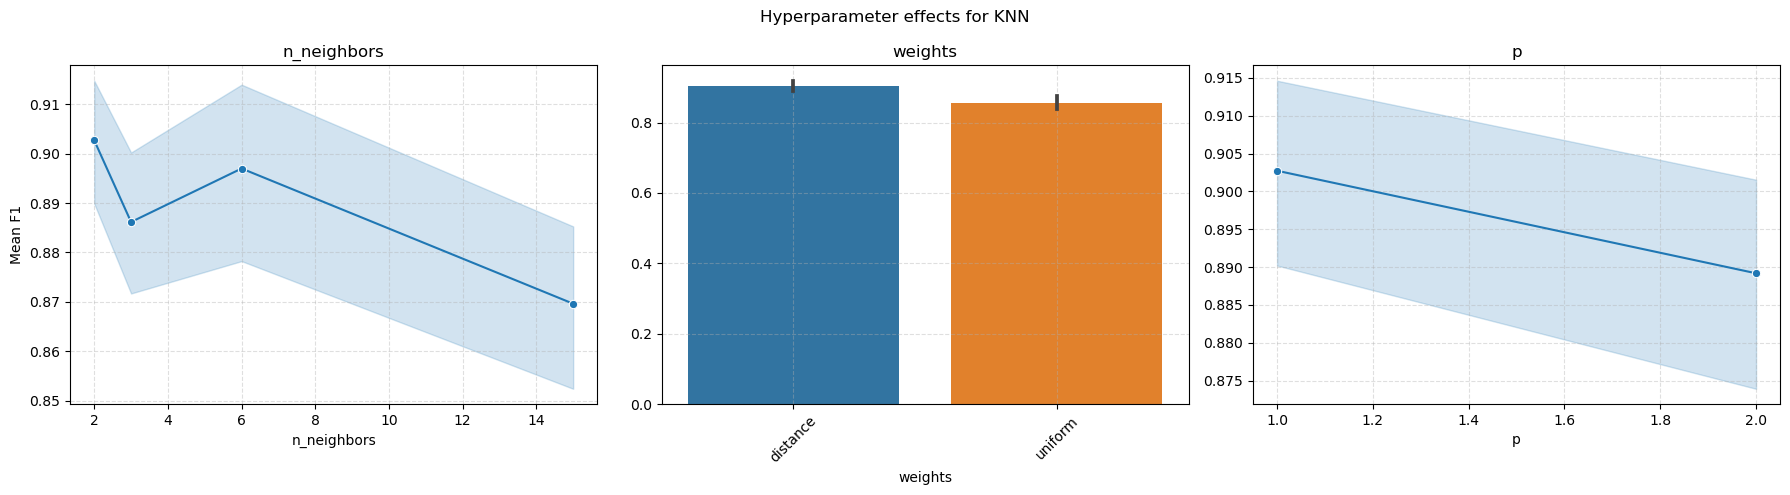

In [61]:
plot_hyperparameter_effects(KNN_results, 'KNN', KNN_params, KNN_best_params)

### 7.4 Best Performing Model

In [49]:
print("Best Performing Models:")
print(f"Random Forest: F1 Macro = {randomForest_best['mean_test_f1']:.4f}, Params = {randomForest_best_params}")
print(f"XGBoost: F1 Macro = {XGBoost_best['mean_test_f1']:.4f}, Params = {XGBoost_best_params}")
print(f"KNN: F1 Macro = {KNN_best['mean_test_f1']:.4f}, Params = {KNN_best_params}")

Best Performing Models:
Random Forest: F1 Macro = 0.9296, Params = {'n_estimators': 100, 'max_depth': 10}
XGBoost: F1 Macro = 0.9413, Params = {'n_estimators': 1500, 'max_depth': 10, 'learning_rate': 0.1}
KNN: F1 Macro = 0.9616, Params = {'n_neighbors': 6, 'weights': 'uniform', 'p': 1}


### 7.5 K-fold Crossvalidation

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import clone
from sklearn.model_selection import ParameterGrid

import importlib
import classifierConfigs as cc
importlib.reload(cc)
from classifierConfigs import get_classifier_configs, get_scorings

def cross_validate_classifiers(
    X, y,
    preprocessing_configs,
    classifiers,
    cv_folds=5,
    scoring=None,
    results_dir="breast-cancer/cv_results"
):
    os.makedirs(results_dir, exist_ok=True)
    
    all_results = []

    for pidx, prep_config in enumerate(preprocessing_configs):
        print(f"\n[{pidx+1}/{len(preprocessing_configs)}] Preprocessing: {prep_config['name']}")
        
        X_cp = X.copy()
        y_cp = y.copy()
        
        if prep_config['outlier_q'] != -1:
            X_cp = remove_outliers(X_cp, prep_config['outlier_q'], 1-prep_config['outlier_q'])
            y_cp = y_cp.loc[X_cp.index]
        
        if prep_config['correlation_threshold'] != -1:
            X_cp, to_drop = drop_highly_correlated_features(X_cp, prep_config['correlation_threshold'])
        
        X_cp = X_cp[X_cp.columns]
        
        scaling = prep_config['scaling']
        preprocessor = build_preprocessing_pipeline(
            features=X_cp.columns,
            scaling=False if scaling is False else True,
            scaler=StandardScaler() if scaling == 'Standard' else (MinMaxScaler() if scaling == 'MinMax' else None)
        )
        
        for clf_name, cfg in classifiers.items():
            print(f"  Classifier: {clf_name}")
            
            model = cfg['model']
            param_grid = cfg.get('param_grid', {})
            
            skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
            
            for params in ParameterGrid(param_grid) if param_grid else [{}]:
                clf_instance = clone(model).set_params(**params)
                
                pipe = Pipeline([
                    ('preprocessor', preprocessor),
                    ('classifier', clf_instance)
                ])
                
                scores = cross_validate(
                    pipe,
                    X_cp,
                    y_cp,
                    cv=skf,
                    scoring=scoring,
                    return_train_score=True,
                    n_jobs=-1
                )
                
                result = {
                    'preprocessing': prep_config['name'],
                    'classifier': clf_name,
                    'params': params,
                    'train_accuracy_mean': np.mean(scores['train_accuracy']),
                    'train_f1_mean': np.mean(scores['train_f1']),
                    'test_accuracy_mean': np.mean(scores['test_accuracy']),
                    'test_f1_mean': np.mean(scores['test_f1']),
                    'n_samples': X_cp.shape[0],
                    'n_features': X_cp.shape[1]
                }
                
                all_results.append(result)
                
    df_results = pd.DataFrame(all_results)
    timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
    df_results.to_csv(os.path.join(results_dir, f"cv_results_{timestamp}.csv"), index=False)
    
    return df_results

scoring = get_scorings(multiclass=False)
classifiers = get_classifier_configs(task='binary')
cv_results_df = cross_validate_classifiers(
    training_df_cleaned.drop(columns=[TARGET]),
    y = training_df_cleaned[TARGET],
    preprocessing_configs=preprocessing_configs,
    classifiers=classifiers,
    cv_folds=5,
    scoring=scoring,
    results_dir="breast-cancer/cv_results"
)



[1/27] Preprocessing: Outlier-Quantile: None + Correlation-Threshold: None + Scaling: False
  Classifier: KNN
  Classifier: Random Forest
  Classifier: XGBoost

[2/27] Preprocessing: Outlier-Quantile: None + Correlation-Threshold: 0.9 + Scaling: False
  Classifier: KNN
  Classifier: Random Forest
  Classifier: XGBoost

[3/27] Preprocessing: Outlier-Quantile: None + Correlation-Threshold: 0.95 + Scaling: False
  Classifier: KNN
  Classifier: Random Forest
  Classifier: XGBoost

[4/27] Preprocessing: Outlier-Quantile: 0.01 + Correlation-Threshold: None + Scaling: False
  Classifier: KNN
  Classifier: Random Forest


---

## Appendix: Kaggle

In [124]:
# validation_df_eng = add_engineered_features(validation_df)
# validation_df = validation_df_eng

def tt_split(X, y, target=TARGET):
    X_train = X.copy()
    y_train = y.copy() if y is not None else None
    X_test = validation_df.drop(columns=[target]) if target in validation_df.columns else validation_df.copy()
    y_test = validation_df[target] if target in validation_df.columns else None
    
    return X_train, X_test, y_train, y_test

X = df.drop(columns=[TARGET])
y = df[TARGET]

X_train, X_test, y_train, y_test = tt_split(X, y, target=TARGET)
print('Training set shape:', X_train.shape)
print('Test set shape:', X_test.shape)


Training set shape: (285, 30)
Test set shape: (284, 31)


In [126]:
import os 
from datetime import datetime

kaggle_dir = 'breast-cancer/kaggle'
os.makedirs(kaggle_dir, exist_ok=True)

def predict_provided_test_file(
    X_train, X_test, y_train, y_test,
    prep_config,
    classifier,
):
    X_train_cp = X_train.copy()
    X_test_cp = X_test.copy()
    
    if prep_config['outlier_q'] != -1:
        X_train_cp = remove_outliers(X_train_cp, prep_config['outlier_q'], 1-prep_config['outlier_q'])
        X_test_cp = remove_outliers(X_test_cp, prep_config['outlier_q'], 1-prep_config['outlier_q'])
            
    if prep_config['correlation_threshold'] != -1:
        X_train_cp, to_drop = drop_highly_correlated_features(X_train_cp, prep_config['correlation_threshold'])
        X_test_cp = X_test_cp.drop(columns=to_drop)
        
    X_test_cp = X_test_cp[X_train_cp.columns]

    scaling_options = prep_config['scaling']
    base_preprocessor = build_preprocessing_pipeline(
        features=X_train_cp.columns,
        scaling=False if scaling_options is False else True,
        scaler=StandardScaler() if scaling_options == 'Standard' else (
                MinMaxScaler() if scaling_options == 'MinMax' else None)
        )
    
    if base_preprocessor is None:
        pipeline = Pipeline([
            ('classifier', classifier)
        ])
    else:
        preprocessor = clone(base_preprocessor)
        pipeline = Pipeline([
            ('preprocesser', preprocessor),
            ('classifier', classifier)
        ])
    pipeline.fit(X_train, y_train)
            
    y_pred_test = pipeline.predict(X_test).astype(bool)
    
    if 'ID' in X_test.columns:
        result = pd.DataFrame({
            'ID': X_test['ID'].values,
            'class': y_pred_test
        })
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    csv_file = f"{kaggle_dir}/predictions_{timestamp}.csv"
    
    result.to_csv(csv_file, index=False)
    
import sklearn
print("scikit-learn:", sklearn.__version__)
print("pandas:", pd.__version__)
print("numpy:", np.__version__)

scikit-learn: 1.2.1
pandas: 1.5.3
numpy: 1.23.5


In [ ]:
# second try
prep_config = preprocessing_configs[26]
classifier = get_xgb_classifiers(task='binary')[0]
print(prep_config)

predict_provided_test_file(
    X_train, X_test, y_train, y_test,
    prep_config=prep_config,
    classifier=classifier
)

{'name': 'Outlier-Quantile: 0.05 + Correlation-Threshold: 0.95 + Scaling: MinMax', 'scaling': 'MinMax', 'outlier_q': 0.05, 'correlation_threshold': 0.95}
<bound method XGBModel.get_params of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, ...)>


In [127]:
# third try
prep_config = {
        "name": "Outlier-Quantile: 0.05 + Correlation-Threshold: None + Scaling: MinMax",
        "scaling": 'MinMax',
        "outlier_q": 0.05,
        "correlation_threshold": -1,
}

classifier = KNeighborsClassifier(
    n_neighbors=2,
    p=1,
    weights='distance'
)

predict_provided_test_file(
    X_train, X_test, y_train, y_test,
    prep_config=prep_config,
    classifier=classifier
)